# AXA coding challenge - data visualization and analysis
Data:
1. Citibike: https://s3.amazonaws.com/tripdata/index.html
2. NYPD:  https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

In [1]:
# Import modules
import os # basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter  # to set y-values to scientific
import seaborn as sns
import time
import sklearn as sk
import statsmodels.api as sm
from scipy import stats
import dask.dataframe as dd
import pickle

import folium # library for interactive map visualizations
from folium.plugins import HeatMap
import geopandas

import sys
sys.path.append("C:/Users/Hanna/sciebo/Python_scripts")
from statistical_test import * # extensive script for stats I use often, created by one of my colleagues, Kamil Pradel
import pingouin
import warnings

current_dir = os.getcwd() # current dir
sys.path.append(current_dir)
from 3_functions import * # my functions used in this notebook

%matplotlib inline
plt.rcParams['axes.labelsize'] = 20

In [22]:
# Functions
def plot_sum_timeline(df, variables, period, xy_labels, plot_title, label_colours_dict, save_name):
    '''
    Function plotting one or more variables (column names) over time, taking the sum per month or year
    
    - variables: col name (str) or list of col names (str)
    - label_colours_dict: dict variable: colour -> label will be first matched to variable (col name), then taken from last part of name, eg if variable
        is 'number_of_cyclist_injured', label will be 'injured'
    - save_name: name of figure. Figure will be saved in fig_dir, as save_fig_as
    '''
    
    if period == 'month':
        period = ['year', 'month']
    
    # Create sum of variables per year and month
    period_sum = (
        df_accidents.groupby(period)[variables]
        .sum()
        .reset_index()
    )

    #print(monthly_sum.head()) # check 
    period_sum['date'] = pd.to_datetime(period_sum[period].assign(day=1))

    # Plot
    plt.close()
    fig, axes = plt.subplots(len(variables),1, figsize=(12, 4*len(variables)), sharex=False); axes = axes.flatten();
    plt.suptitle(plot_title)
    for i, var in enumerate(variables):
        label = var.split('_')[-1]
        axes[i].plot(period_sum['date'], period_sum[var], marker='o', color=label_colours_dict[var], label=label)
        axes[i].set_xlabel(xy_labels[0][i])
        axes[i].set_ylabel(xy_labels[1][i])
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid()
        axes[i].legend()
        plt.tight_layout()

    fig.savefig(os.path.join(results_dir, save_name), format=save_fig_as) # save figure
    plt.show()
    
def plot_combined_bike_metrics(df):
    
    df_bike_collisions = df[df['bike_involved'] == 'bike'] # filter rows where a bike is involved
    # new column to identify whether a cyclist was injured or killed
    df_bike_collisions['cyclist_hurt'] = df_bike_collisions['number_of_cyclists_injured'] + df_bike_collisions['number_of_cyclists_killed']
    
    # group by time period (year or month) and calculate the total number of collisions
    total_collisions = (df.groupby(['year', 'month']).size().reset_index(name='total_collisions'))

    # Calculate the total number of cyclists injured or killed for each month
    cyclist_hurt_by_month = (
        df_bike_collisions.groupby(['year', 'month'])['cyclist_hurt']
        .sum()
        .reset_index(name='total_cyclist_hurt')
    )

    merged_data = pd.merge(total_collisions, cyclist_hurt_by_month, on=['year', 'month'], how='left').fillna(0) # merge both dfs on year and month
    merged_data['cyclist_hurt_percentage'] = (merged_data['total_cyclist_hurt'] / merged_data['total_collisions']) * 100 # % cyclists injured or killed out of total collisions
    merged_data['date'] = pd.to_datetime(merged_data[['year', 'month']].assign(day=1))  # convert year and month to a datetime column for plotting

    bike_collision_filter = df[['bike_involved']].eq('bike').any(axis=1) # filter bike collisions
    df['is_bike_collision'] = bike_collision_filter

    # count bike collisions
    df['crash_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    monthly_totals = df.groupby('crash_month').size().reset_index(name='total_collisions')
    bike_collisions = df[df['is_bike_collision']].groupby('crash_month').size().reset_index(name='bike_collisions')

    bike_collision_data = pd.merge(monthly_totals, bike_collisions, on='crash_month', how='left').fillna(0)

    # % of bike collisions
    bike_collision_data['bike_collision_percentage'] = (bike_collision_data['bike_collisions'] / bike_collision_data['total_collisions']) * 100

    plt.close()
    fig = plt.figure(figsize=(12, 6))

    # % collisions involving bike
    plt.plot(bike_collision_data['crash_month'], bike_collision_data['bike_collision_percentage'], marker='o', color='blue', 
             label='Percentage of bike collisions (% of total collisions)')
    # % cyclist injuries/fatalities from total collisions
    plt.plot(merged_data['date'], merged_data['cyclist_hurt_percentage'], marker='o', color='orange', 
             label='Cyclist injury/fatality (% of total collisions)')

    plt.title('Bike collisions')
    plt.xlabel('Date (year, month)')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(results_dir, 'bike_collisions.'+save_fig_as), format=save_fig_as) # save figure


def plot_injured_killed(df, category, iax=0):
    plt.close()
    sns.barplot(data=df[df['type'] == category], x='group', y='count_sum', ax=axs[iax], 
            palette=colour_palette, alpha=0.7, order=['pedestrians','cyclists'])
    sns.stripplot(data=df[df['type'] == category], x='group', y='count_sum', ax=axs[iax], color='black', 
                  dodge=True, size=4, jitter=True, edgecolor='gray', linewidth=0.5, legend=False, order=['pedestrians','cyclists']);
    axs[iax].set_title(f'Average number of people {category}')
    axs[iax].set_ylabel('Avg. number of people/year (#)')
    # add stats to plot
    sum_ = df.loc[df['type'] == category]
    stats_ = statistical_test( {"cyclists": sum_.loc[sum_['group'] == 'cyclists', 'count_sum'], 
                                "pedestrians":  sum_.loc[sum_['group'] == 'pedestrians', 'count_sum']}, pairing='paired');
    p_color = color_p(stats_["p-value"].item(), sign, not_sign); # get color for p-value text, dependen on whether significant
    print(f'{stats_.test.item()} for {category}: p-value = {stats_["p-value"].item():.6f}')
    #print(stats_injured)
    axs[iax].annotate(f'p-value={stats_["p-value"].item():.4f}', xy=(0.5, 0.9), 
                    xycoords='axes fraction', ha='center', va='bottom', fontsize=10, xytext=(0, 10), textcoords='offset points', color=p_color)
    plt.show()
    
def ddf_plot_grouped_timeline(ddf, variable, group_by, xy_labels, plot_title, save_name):
    ddf = ddf.dropna(subset=[variable, group_by]) # drop all rows where variable is NaN 
    ddf = ddf.sort_values(by='start_datetime').compute()
    ddf['year'] = ddf['start_datetime'].dt.year.astype('int32')
    ddf['month'] = ddf['start_datetime'].dt.month.astype('int32')
    
    bike_rides_number_month = ( # Calculate the count for each month
        ddf.groupby(['year','month', group_by])[variable]
        .count().reset_index()#.compute()
    )
    bike_rides_sum_month = ( # Calculate the sum for each month
        ddf.groupby(['year','month', group_by])[variable]
        .sum().reset_index()#.compute()
    )

    bike_rides_number_month['date'] = pd.to_datetime(bike_rides_number_month[['year','month']].assign(day=1))
    bike_rides_sum_month['date'] = pd.to_datetime(bike_rides_sum_month[['year','month']].assign(day=1))
    
    formatter = ScalarFormatter(useMathText=True) # adjust power limits to enforce scientific notation
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 4))  
    
    plt.close()
    fig, axes = plt.subplots(2,1, figsize=(12, 12), sharex=True); axes = axes.flatten();
    plt.suptitle(plot_title)
    
    unique_groups = bike_rides_number_month[group_by].unique()
    for group in unique_groups:
        group_data_count = bike_rides_number_month[bike_rides_number_month[group_by] == group]
        group_data_sum = bike_rides_sum_month[bike_rides_sum_month[group_by] == group]
        # Plot the count per group
        axes[0].plot(group_data_count['date'], group_data_count[variable], marker='o', linewidth=3, markersize=5, label=f'{group}')
    
        # Plot the sum per group
        axes[1].plot(group_data_sum['date'], group_data_sum[variable], marker='o', linewidth=3, markersize=5, label=f'{group}')
    
    #axes[0].plot(bike_rides_number_month['date'], bike_rides_number_month[variable], marker='o', color=label_colours_dict[var], label='count')
    axes[0].set_xlabel(xy_labels[0][0])
    axes[0].set_ylabel(xy_labels[1][0])
    axes[0].set_title('Rental count')
    axes[0].yaxis.set_major_formatter(formatter) # format y-values as scientific for better readability
    axes[0].tick_params(axis='x', rotation=45)
    #axes[0].set_xlim([])
    axes[0].grid()
    axes[0].legend(title='Age group')
    
    #axes[1].plot(bike_rides_sum_month['date'], bike_rides_sum_month[variable], marker='o', color=label_colours_dict[var], label='count')
    axes[1].set_xlabel(xy_labels[0][1])
    axes[1].set_ylabel(xy_labels[1][1])
    axes[1].set_title('Rental duration')
    axes[1].yaxis.set_major_formatter(formatter) # format y-values as scientific for better readability
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid()
    axes[1].legend(title='Age group')
    plt.tight_layout()
    
    fig.savefig(save_name, format='jpg') # save figure
    plt.show()

def plot_grouped_ride_duration_bars(df, variable, group_by, xy_labels, plot_title, save_name, filter_years=[]):

    if filter_years: # if select only specific years
        df = df.loc[df['start_datetime'].dt.year.between(filter_years[0], filter_years[1])]
        plot_title = plot_title + f' ({filter_years[0]}-{filter_years[1]})' # update title
        save_name = save_name +  f'_{filter_years[0]}-{filter_years[1]}' # update save name
        
    df_yearly = df.groupby(group_by).agg({
        variable: 'sum'
    }).reset_index().compute()
    
    n_groups = len(ddf[group_by].unique().compute()) # n groups

    plt.close()
    sns.set_theme(style='whitegrid')
    g = sns.catplot(height=4, aspect=0.34 * n_groups,
        data=df_yearly, kind='bar', 
        x=group_by, y=variable, color='navy', #**plotting_params
    )
    g.despine(left=True)
    g.set_axis_labels(xy_labels[0], xy_labels[1])
    plt.title(plot_title)
    
    g.savefig(save_name, format='jpg') # save figure
    plt.show()

def plot_grouped_ride_count_bars(df, variable, group_by, xy_labels, plot_title, save_name, filter_years=[]):

    if filter_years: # if select only specific years
        df = df.loc[df['start_datetime'].dt.year.between(filter_years[0], filter_years[1])]
        plot_title = plot_title + f' ({filter_years[0]}-{filter_years[1]})' # update title
        save_name = save_name +  f'_{filter_years[0]}-{filter_years[1]}' # update save name
    
    df_yearly = df.groupby(group_by).size().reset_index()  # get size as a Series
    df_yearly.columns = [group_by, 'count']  # rename columns
    df_yearly = df_yearly.compute() 

    n_groups = len(ddf[group_by].unique().compute()) # n groups

    plt.close()
    sns.set_theme(style='whitegrid')
    g = sns.catplot(height=4, aspect=0.37 * n_groups,
        data=df_yearly, kind='bar', 
        x=group_by, y='count', color='lightblue', #**plotting_params
    )
    g.despine(left=True)
    g.set_axis_labels(xy_labels[0], xy_labels[1])
    plt.title(plot_title)

    g.savefig(save_name, format='jpg') # save figure
    plt.show()
    
def annotate_pvals(plot, p_values, ax=None):
    if ax is None:
        ax = plot.ax
    for i, p_value in enumerate(p_values):
        color = color_p(p_value);
        ax.annotate(f'p={p_value:.3f}', (i, 0), xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, color=color)
        
def color_p(pval, sign="crimson", not_sign="slategrey"): # determine colour of p value depicted in figure
    if pval < 0.05: 
        p_color = sign; 
    else:
        p_color = not_sign;
    return p_color

def get_ddf_sum_and_count(df, variable, group_by):
    
    df_sum = df.groupby(group_by).agg({ # trip_duration in hours
        variable: 'sum',
    }).reset_index()
    df_sum=df_sum.sort_values(by='hour').compute()

    df_count = ddf.groupby('hour').agg({ # count of trips
    variable: 'count',
    }).reset_index()
    
    df_count=df_count.sort_values(by='hour').compute()

    return df_sum, df_count


def get_df_count(df, variable, group_by):
    df_count = df.groupby(group_by).agg({
        variable: 'count',
    }).reset_index()
    
    df_count = df_count.sort_values(by=group_by)  # No need for .compute() in Pandas
    
    return df_count

def assign_season(df, time_datetime):

    df = df.dropna(subset=[time_datetime]) # remove row when 'start_datetime' has nans
    
    # Assign seasons based on month (rough estimation)
    #df['season'] = 'winter' # assign winter as defaults
    # df.loc[df['start_datetime'].dt.month.between(4, 6), 'season'] = 'spring'
    # df.loc[df['start_datetime'].dt.month.between(7, 9), 'season'] = 'summer'
    # df.loc[df['start_datetime'].dt.month.between(10, 11), 'season'] = 'fall'

    df['season'] = np.nan
    
    # Assigning seasons based on specific date ranges
    df.loc[(df[time_datetime].dt.month == 12) & (df[time_datetime].dt.day >= 21), 'season'] = 'winter'
    df.loc[(df[time_datetime].dt.month == 1) | (df[time_datetime].dt.month == 2), 'season'] = 'winter'
    df.loc[(df[time_datetime].dt.month == 3) & (df[time_datetime].dt.day <= 20), 'season'] = 'winter'
    
    df.loc[(df[time_datetime].dt.month == 3) & (df[time_datetime].dt.day >= 21), 'season'] = 'spring'
    df.loc[(df[time_datetime].dt.month == 4) | (df[time_datetime].dt.month == 5), 'season'] = 'spring'
    df.loc[(df[time_datetime].dt.month == 6) & (df[time_datetime].dt.day <= 20), 'season'] = 'spring'
    
    df.loc[(df[time_datetime].dt.month == 6) & (df[time_datetime].dt.day >= 21), 'season'] = 'summer'
    df.loc[(df[time_datetime].dt.month == 7) | (df[time_datetime].dt.month == 8), 'season'] = 'summer'
    df.loc[(df[time_datetime].dt.month == 9) & (df[time_datetime].dt.day <= 22), 'season'] = 'summer'
    
    df.loc[(df[time_datetime].dt.month == 9) & (df[time_datetime].dt.day >= 23), 'season'] = 'autumn'
    df.loc[(df[time_datetime].dt.month == 10) | (df[time_datetime].dt.month == 11), 'season'] = 'autumn'
    df.loc[(df[time_datetime].dt.month == 12) & (df[time_datetime].dt.day <= 20), 'season'] = 'autumn'

    return df


In [4]:
# Some settings
cleaned_dir = current_dir + '/clean_data/' # directory where clean data is saved
cleaned_dir_bike_rides = cleaned_dir + 'bike-tripdata_cleaned' # directory where cleaned and concatenated bike-trip data is saved
results_dir = current_dir + '/results' # directory where figures will be saved
if not os.path.exists(results_dir): # create if doens´t exist
    os.makedirs(results_dir) 
    
save_fig_as = 'jpg' # save figures as, eg 'pdf', 'jpg', 'svg', 'png'
sign="crimson"; not_sign="slategrey" # colors p_val text

warnings.filterwarnings("ignore")

# Accident data
## Get a sense of the severity of bike accidents in NYC; how often do they occur, what % of collisions involved a cyclist, what % of collisions caused injuries/death?

In [26]:
# Load accident data
df_accidents = pd.read_csv(cleaned_dir + '/collisions_cleaned.csv')
print(f'Total number of accidents (between 2012 and 2024): {df_accidents.shape[0]}')
print(f'Number of bike accidents (between 2012 and 2024): {df_accidents.loc[df_accidents['bike_involved']=='bike'].shape[0]}')

df_accidents.drop('Unnamed: 0', axis=1, inplace=True)

df_bike_accidents = df_accidents.loc[df_accidents['bike_involved']=='bike']
df_accidents.columns

Total number of accidents (between 2012 and 2024): 2120518
Number of bike accidents (between 2012 and 2024): 78939


Index(['borough', 'zip_code', 'accident_latitude', 'accident_longitude',
       'location', 'on_street_name', 'cross_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclists_injured', 'number_of_cyclists_killed',
       'number_of_motorists_injured', 'number_of_motorists_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'contributing_factor_vehicle_3', 'contributing_factor_vehicle_4',
       'contributing_factor_vehicle_5', 'collision_id', 'vehicle_type_code_1',
       'vehicle_type_code_2', 'vehicle_type_code_3', 'vehicle_type_code_4',
       'vehicle_type_code_5', 'crash_datetime', 'year', 'month',
       'bike_involved'],
      dtype='object')

In [12]:
df_accidents.dtypes

borough                           object
zip_code                         float64
accident_latitude                float64
accident_longitude               float64
location                          object
on_street_name                    object
cross_street_name                 object
off_street_name                   object
number_of_persons_injured          int64
number_of_persons_killed           int64
number_of_pedestrians_injured      int64
number_of_pedestrians_killed       int64
number_of_cyclists_injured         int64
number_of_cyclists_killed          int64
number_of_motorists_injured        int64
number_of_motorists_killed         int64
contributing_factor_vehicle_1     object
contributing_factor_vehicle_2     object
contributing_factor_vehicle_3     object
contributing_factor_vehicle_4     object
contributing_factor_vehicle_5     object
collision_id                       int64
vehicle_type_code_1               object
vehicle_type_code_2               object
vehicle_type_cod

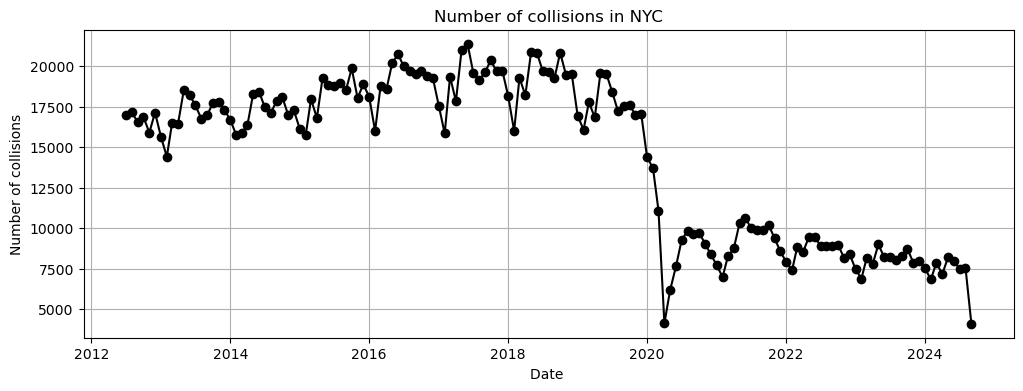

In [59]:
# Create sum of variables per year and month
monthly_count = (
    df_accidents.groupby(['year', 'month'])['number_of_cyclists_injured']
    .count()
    .reset_index()
)

monthly_count['date'] = pd.to_datetime(monthly_count[['year', 'month']].assign(day=1))

# Plot
fig, axes = plt.subplots(1,1, figsize=(12, 4), sharex=True);
axes.plot(monthly_count['date'], monthly_count['number_of_cyclists_injured'], marker='o', color='k', label='Total collisions (#)')
#axes[i].plot(monthly_accidents['date'], monthly_accidents[var], marker='o', color=label_colours_dict[var], label=label)
axes.set_xlabel('Date ')
axes.set_title('Number of collisions in NYC')
axes.set_ylabel('Number of collisions')
#axes.tick_params(axis='x', rotation=45)
axes.grid()

fig.savefig(os.path.join(results_dir,'monthly_collisions_total.jpg'), format='jpg') # save figure

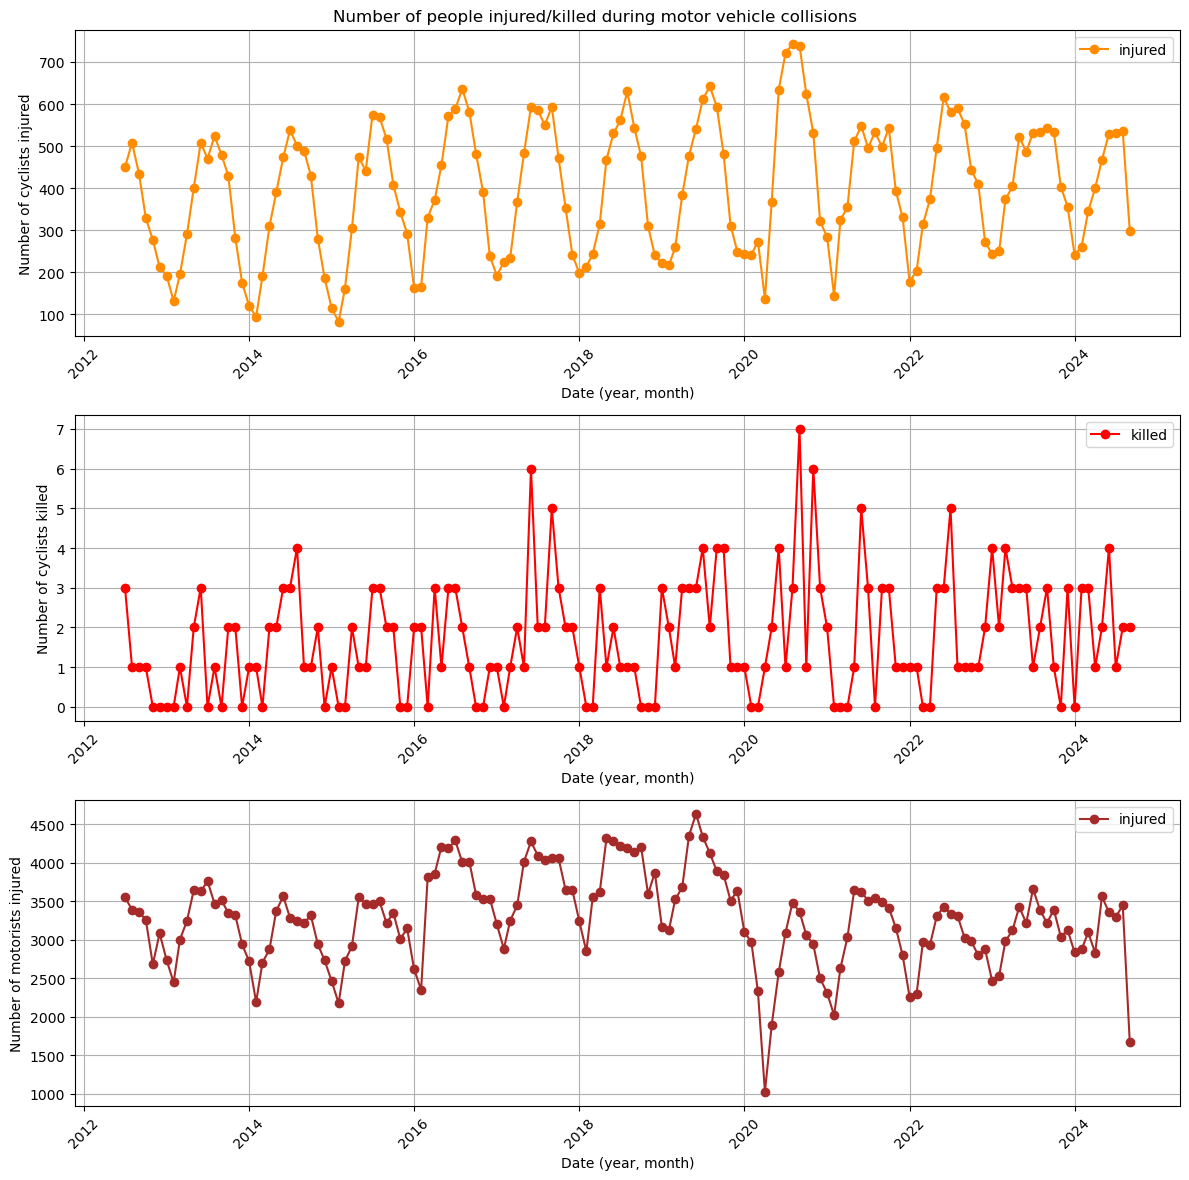

In [36]:
variables = ['number_of_cyclists_injured','number_of_cyclists_killed','number_of_motorists_injured']
period = 'month'
xy_labels = [['Date (year, month)','Date (year, month)','Date (year, month)'],['Number of cyclists injured','Number of cyclists killed','Number of motorists injured']]
plot_title = 'Number of people injured/killed during motor vehicle collisions'
label_colours_dict = {'number_of_cyclists_injured':'darkorange','number_of_cyclists_killed':'red','number_of_motorists_injured':'brown'}
save_name = 'monthly_accidents.jpg'

plot_sum_timeline(df_accidents, variables, period, xy_labels, plot_title, label_colours_dict, save_name)

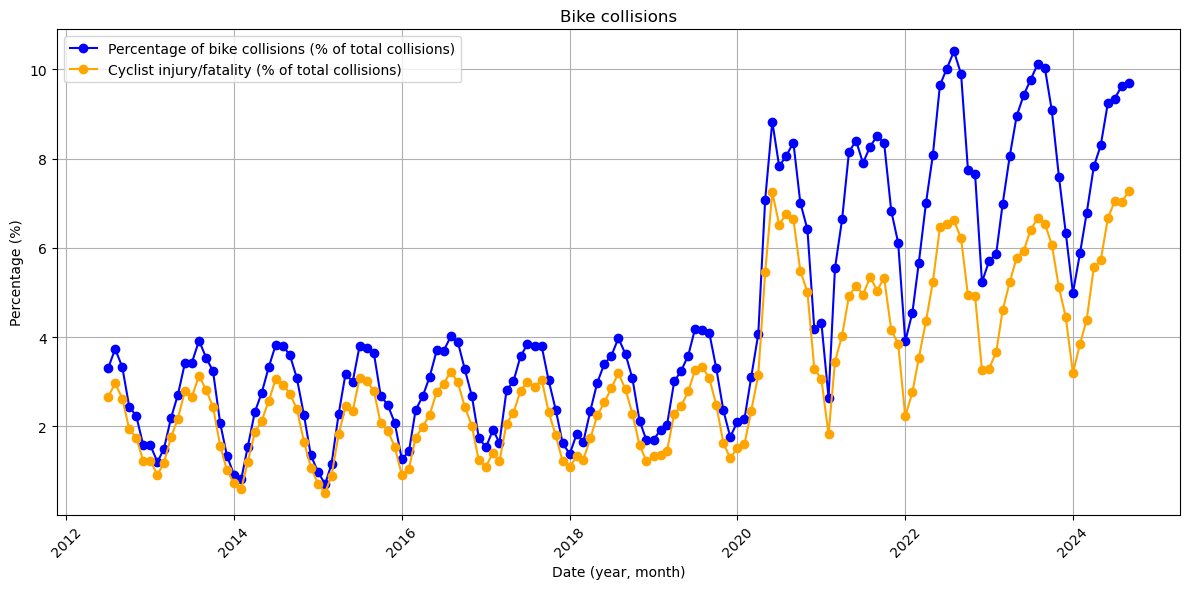

In [60]:
# How many of the collisions involved a bike? And how many involved injured/killed cyclists?
# to avoid error, try: 
pd.options.mode.copy_on_write = True 
plot_combined_bike_metrics(df_accidents)

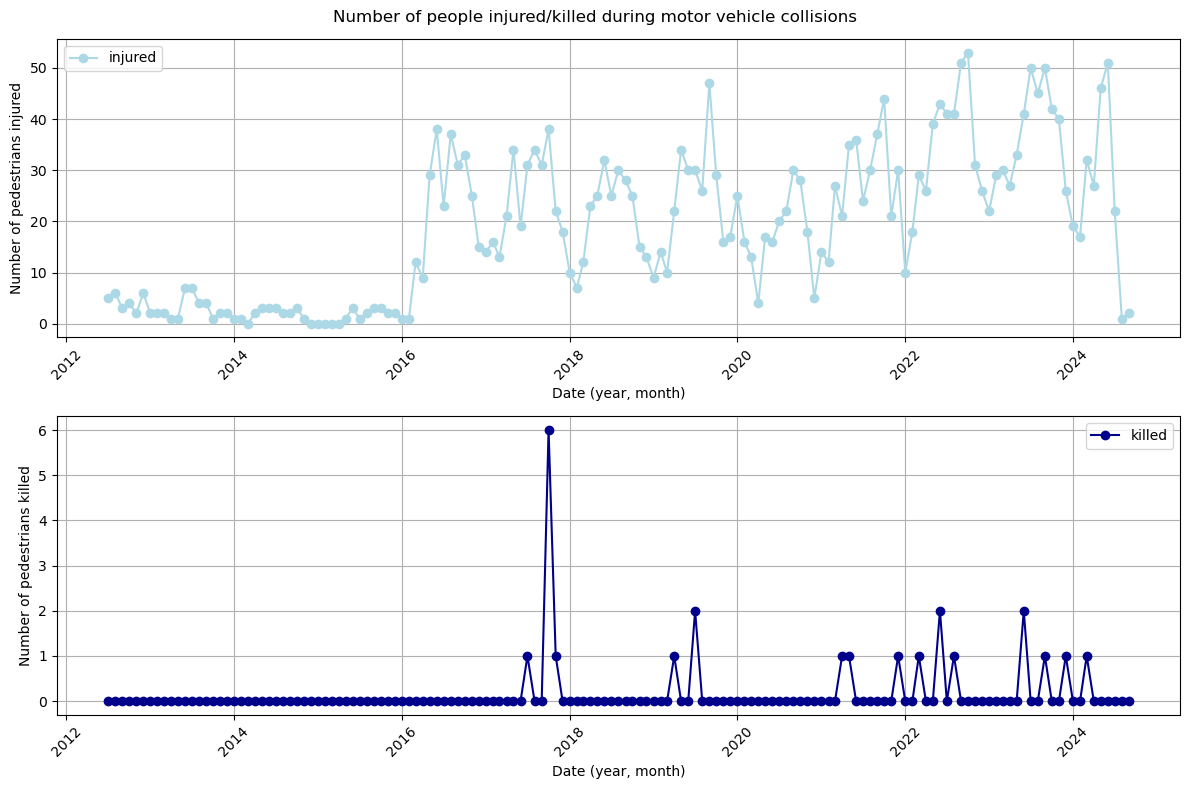

In [108]:
variables = ['number_of_pedestrians_injured','number_of_pedestrians_killed']
period = 'month'
xy_labels = [['Date (year, month)','Date (year, month)'],
             ['Number of pedestrians injured','Number of pedestrians killed']]
plot_title = 'Number of people injured/killed during motor vehicle collisions'
label_colours_dict = {'number_of_cyclists_injured':'darkorange','number_of_cyclists_killed':'red',
                      'number_of_pedestrians_injured':'lightblue','number_of_pedestrians_killed':'darkblue'}
save_name = 'monthly_accidents_pedestrians.jpg'

plot_sum_timeline(df_accidents, variables, period, xy_labels, plot_title, label_colours_dict, save_name)

In [141]:
df_accidents.head()

,Unnamed: 0,borough,zip_code,accident_latitude,accident_longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,...,vehicle_type_code_4,vehicle_type_code_5,crash_datetime,year,month,bike_involved,is_bike_collision,crash_month,lat_bin,lon_bin
4,4,brooklyn,11215,40.677406,-73.983048,"(40.6774056, -73.9830482)",4 avenue,union street,unknown,0,...,unknown,unknown,2012-07-01 00:20:00,2012,7,bike,True,2012-07-01,"(40.656, 40.703]","(-74.043, -73.983]"
42,42,manhattan,10065,40.764162,-73.968890,"(40.7641617, -73.9688897)",east 61 street,park avenue,unknown,1,...,unknown,unknown,2012-07-01 02:30:00,2012,7,bike,True,2012-07-01,"(40.75, 40.797]","(-73.983, -73.922]"
98,98,bronx,10468,40.862679,-73.909040,"(40.8626793, -73.9090397)",sedgwick avenue,west fordham road,unknown,1,...,unknown,unknown,2012-07-01 06:50:00,2012,7,bike,True,2012-07-01,"(40.844, 40.89]","(-73.922, -73.862]"
108,108,brooklyn,11218,40.633745,-73.972283,"(40.633745, -73.9722831)",ocean parkway,avenue f,unknown,0,...,unknown,unknown,2012-07-01 07:30:00,2012,7,bike,True,2012-07-01,"(40.609, 40.656]","(-73.983, -73.922]"
202,202,brooklyn,11211,40.711801,-73.942229,"(40.7118008, -73.9422288)",grand street,humboldt street,unknown,1,...,unknown,unknown,2012-07-01 12:15:00,2012,7,bike,True,2012-07-01,"(40.703, 40.75]","(-73.983, -73.922]"


Wilcoxon signed-rank test (paired) for injured: p-value = 0.000244
Wilcoxon signed-rank test (paired) for killed: p-value = 0.000244
t-test (paired) for injured: p-value = 0.000000
t-test (paired) for killed: p-value = 0.002155


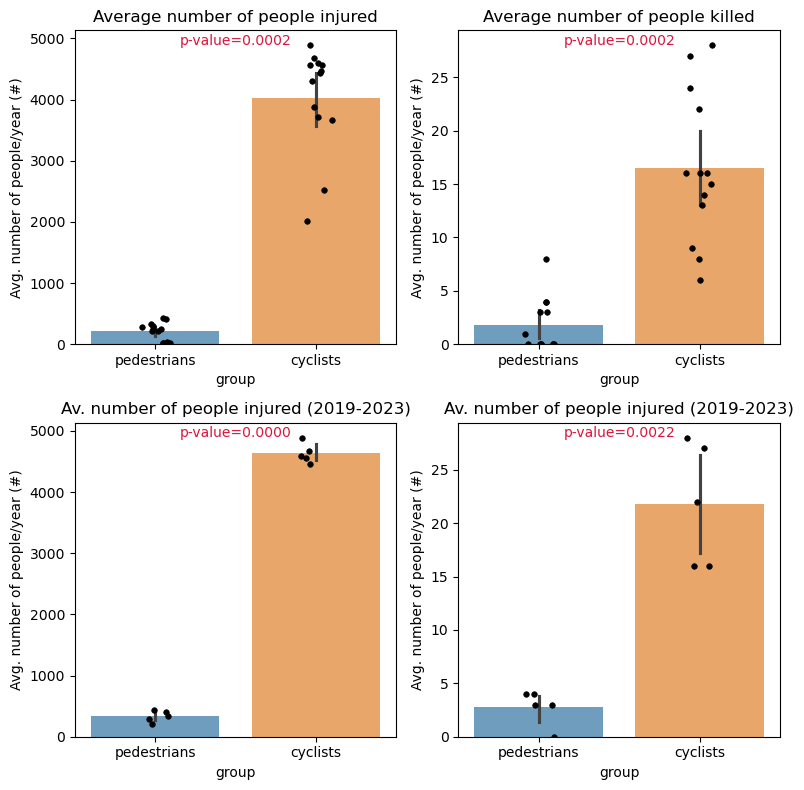

In [209]:
# Are more cyclists injured/killed than pedestrians?
#df_accidents.group_by(['year'])
colour_palette = {'pedestrians': '#1f77b4','cyclists': '#ff7f0e' }
select_years = (2019,2023)

df_yearly = df_accidents.groupby('year').agg({
    'number_of_cyclists_injured': 'sum',
    'number_of_pedestrians_injured': 'sum',
    'number_of_cyclists_killed': 'sum',
    'number_of_pedestrians_killed': 'sum'
}).reset_index()

df_melted = df_yearly.melt(id_vars='year', 
                           value_vars=['number_of_cyclists_injured', 'number_of_pedestrians_injured',
                                       'number_of_cyclists_killed', 'number_of_pedestrians_killed'],
                           var_name='category', value_name='count_sum')

# Create a new column to distinguish injured vs killed
df_melted['type'] = df_melted['category'].apply(lambda x: 'injured' if 'injured' in x else 'killed')
df_melted['group'] = df_melted['category'].apply(lambda x: 'cyclists' if 'cyclists' in x else 'pedestrians')

fig, axs = plt.subplots(2, 2, figsize=(8, 8)); axs = axs.flatten()

plot_injured_killed(df_melted, 'injured', 0)
plot_injured_killed(df_melted, 'killed', 1)

select_years = (2019,2023) # select time period

df_melted_sel = df_melted.loc[df_melted['year'].between(select_years[0],select_years[1])]
plot_injured_killed(df_melted_sel, 'injured', 2)
axs[2].set_title(f'Av. number of people {category} ({select_years[0]}-{select_years[1]})')
plot_injured_killed(df_melted_sel, 'killed', 3)
axs[3].set_title(f'Av. number of people {category} ({select_years[0]}-{select_years[1]})')
plt.tight_layout()

fig.savefig(os.path.join(results_dir,'accidents_injuries-killed_pedestrians-cyclists.jpg'), format='jpg') # save figure

In [189]:
# p-values are the same for injured and killed, yet there are no mistakes. Check the stats values to be sure
print(stats_killed)
print(stats_injured)

   cyclists_mean  pedestrians_mean  cyclists_SD  pedestrians_SD  cyclists_SEM  \
0      16.461538          1.769231     6.732417        2.390811      1.867237   

   pedestrians_SEM  cyclists_median  pedestrians_median  cyclists_Q1  \
0         0.663092             16.0                 0.0         13.0   

   pedestrians_Q1  cyclists_Q3  pedestrians_Q3  cyclists_N  pedestrians_N  \
0             0.0         22.0             3.0          13             13   

                                 test  statistic   p-value  df  
0  Wilcoxon signed-rank test (paired)        0.0  0.000244 NaN  
   cyclists_mean  pedestrians_mean  cyclists_SD  pedestrians_SD  cyclists_SEM  \
0    4021.076923        213.692308   834.464956      140.604948    231.438938   

   pedestrians_SEM  cyclists_median  pedestrians_median  cyclists_Q1  \
0        38.996796           4441.0               245.0       3715.0   

   pedestrians_Q1  cyclists_Q3  pedestrians_Q3  cyclists_N  pedestrians_N  \
0            35.0     

In [149]:
df_melted

,year,category,count_sum,type,group
0,2012,number_of_cyclists_injured,2016,injured,cyclists
1,2013,number_of_cyclists_injured,3715,injured,cyclists
2,2014,number_of_cyclists_injured,3661,injured,cyclists
3,2015,number_of_cyclists_injured,3877,injured,cyclists
4,2016,number_of_cyclists_injured,4299,injured,cyclists
5,2017,number_of_cyclists_injured,4572,injured,cyclists
6,2018,number_of_cyclists_injured,4441,injured,cyclists
7,2019,number_of_cyclists_injured,4459,injured,cyclists
8,2020,number_of_cyclists_injured,4590,injured,cyclists
9,2021,number_of_cyclists_injured,4559,injured,cyclists


We see that more cyclists than pedestrians get injured and killed during a collision with a motor vehicle (yet even more motorists).

Unfortunately, there is no data about age or gender in the accident dataset, so we can not investigate which gender and age group is most likely to get involved in a collision, to know more specifically what the best target group is for an insurance.

Last thing: what are the biggest causes of bike accidents? (just out of interest, I´ll not further analyse it)

In [138]:
print('Causes of collisions involving (a) cyclist(s):  \n ')# get an idea of the causes
print(df_bike_accidents['contributing_factor_vehicle_1'].value_counts())

Causes of collisions involving (a) cyclist(s):  
 
contributing_factor_vehicle_1
driver inattention/distraction                           18663
unspecified                                              18568
failure to yield right-of-way                             8228
pedestrian/bicyclist/other pedestrian error/confusion     4945
traffic control disregarded                               3259
passing or lane usage improper                            2425
passenger distraction                                     2049
other vehicular                                           1576
following too closely                                     1434
turning improperly                                        1350
unsafe speed                                              1163
driver inexperience                                        926
view obstructed/limited                                    908
passing too closely                                        890
unsafe lane changing                 

### Which time of the day are bike accidents most likely?

In [7]:
df_bike_accidents.head(2)

,Unnamed: 0,borough,zip_code,accident_latitude,accident_longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,...,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,crash_datetime,year,month,bike_involved
4,4,brooklyn,11215.0,40.677406,-73.983048,"(40.6774056, -73.9830482)",4 avenue,union street,unknown,0,...,175808,unknown,bicycle,unknown,unknown,unknown,2012-07-01 00:20:00,2012,7,bike
42,42,manhattan,10065.0,40.764162,-73.968890,"(40.7641617, -73.9688897)",east 61 street,park avenue,unknown,1,...,44909,taxi,bicycle,unknown,unknown,unknown,2012-07-01 02:30:00,2012,7,bike


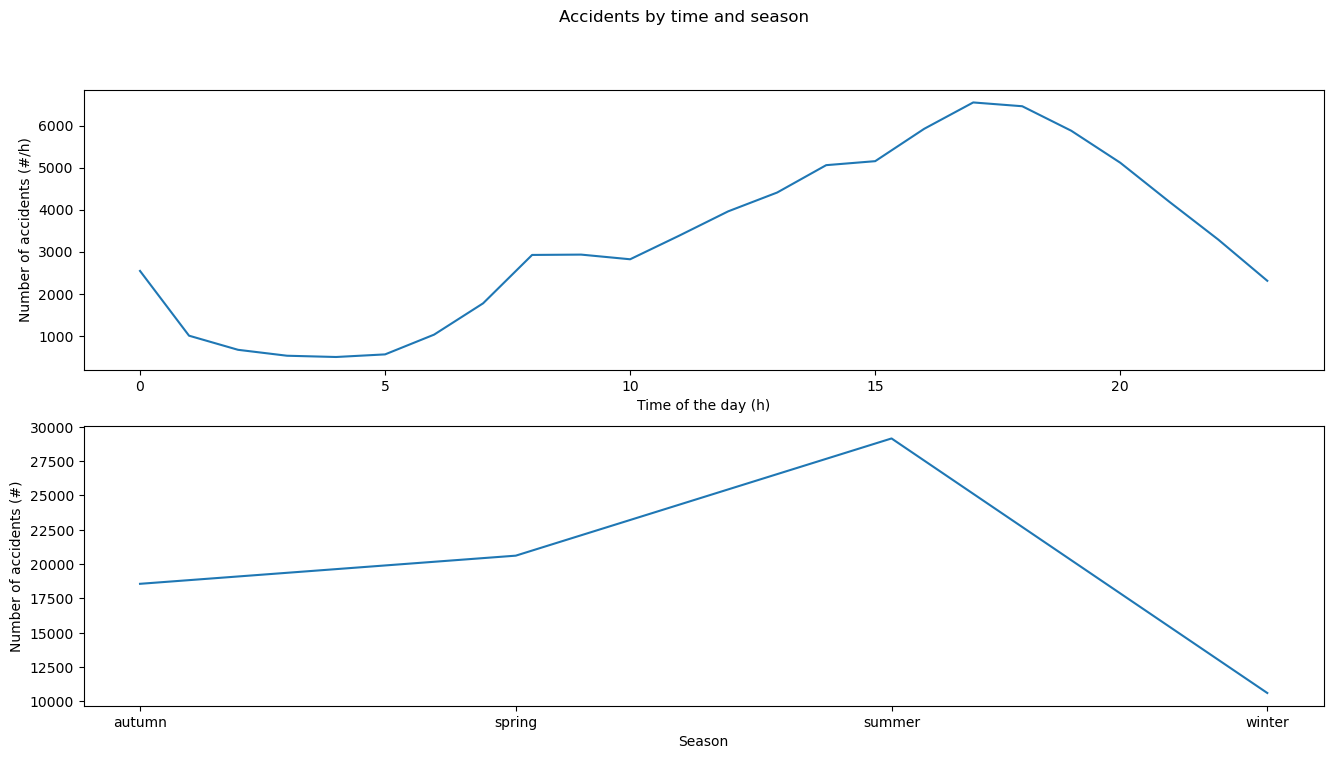

In [10]:
# by HOUR and SEASON

#select_years = (2019,2023)
#df_bike_accidents=df_bike_accidents.loc[df_bike_accidents['year'].between(select_years)]

df_bike_accidents['crash_datetime'] = df_bike_accidents['crash_datetime'].astype('datetime64[ns]')

df_bike_accidents['hour'] = df_bike_accidents['crash_datetime'].dt.hour
df_count_hour = get_df_count(df_bike_accidents,'bike_involved','hour')

df_bike_accidents = assign_season(df_bike_accidents, 'crash_datetime')
df_bike_accidents
df_count_season = get_df_count(df_bike_accidents,'bike_involved','season')

fig, axes = plt.subplots(2, 1, figsize=(16, 8)); axes = axes.flatten()
plt.suptitle(f'Accidents by time and season') #({select_years[0]}-{select_years[1]})
# Accident count
# Per hour
axes[0].plot(df_count_hour['hour'],df_count_hour['bike_involved'])
axes[0].set_xlabel('Time of the day (h)'); axes[0].set_ylabel('Number of accidents (#/h)');
# Per season
axes[1].plot(df_count_season['season'],df_count_season['bike_involved'])
axes[1].set_xlabel('Season'); axes[1].set_ylabel('Number of accidents (#)');


#fig.savefig(os.path.join(results_dir,'bike_rides_per_hour-season.jpg'), format='jpg') # save figure

So we see that most of the accidents happen during late afternoon-early evening, and during summer (the latter as expected).

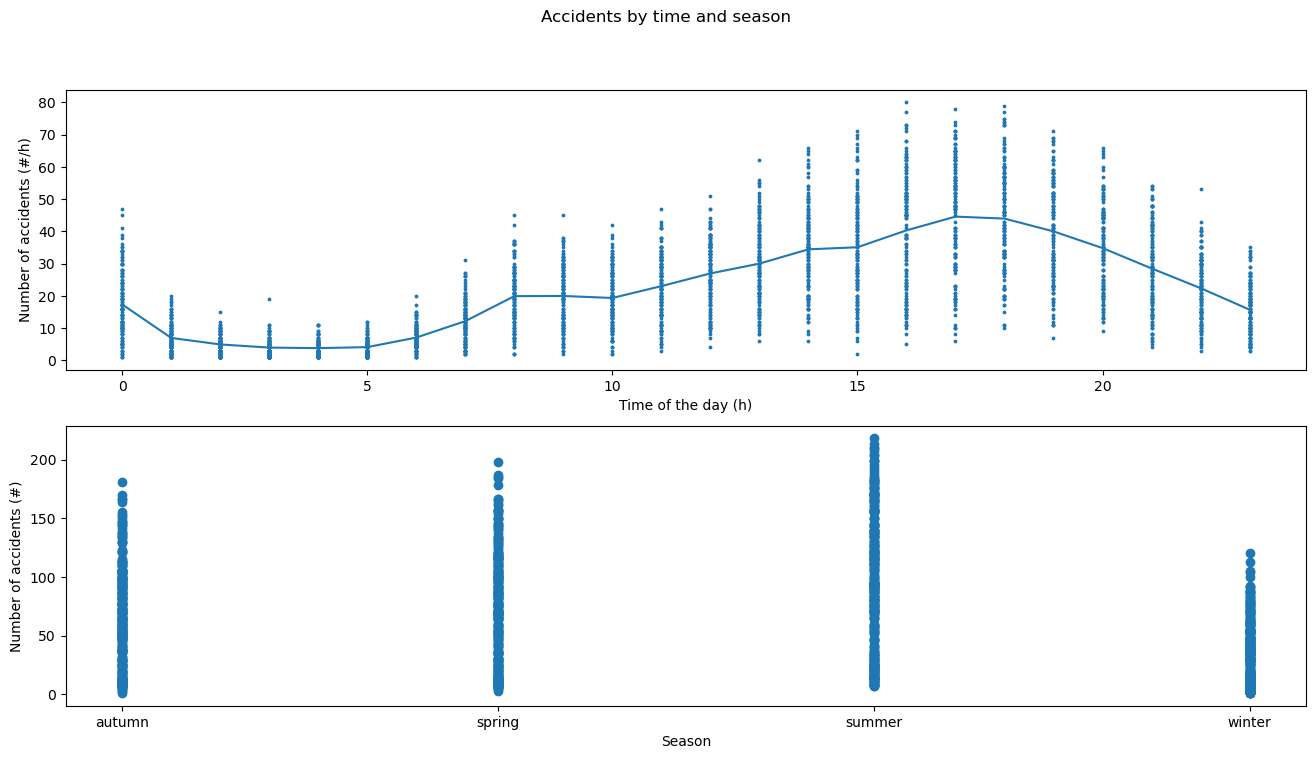

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def get_df_count_grouped(df, variable, group_by):
    df_count = df.groupby([group_by, 'year', 'hour']).agg({variable: 'count'}).reset_index()
    return df_count

df_bike_accidents['day'] = df_bike_accidents['crash_datetime'].dt.day
df_bike_accidents['month'] = df_bike_accidents['crash_datetime'].dt.month

# Group by year and hour, then year and season
df_count_hour = get_df_count_grouped(df_bike_accidents, 'bike_involved', 'month')
df_count_hour_mean = df_count_hour.groupby(['hour']).mean({'bike_involved': 'count'}).reset_index()

df_count_season = get_df_count_grouped(df_bike_accidents, 'bike_involved', 'season')
 
fig, axes = plt.subplots(2, 1, figsize=(16, 8)); axes = axes.flatten()
plt.suptitle(f'Accidents by time and season') 

# Accident count per hour
axes[0].scatter(df_count_hour['hour'], df_count_hour['bike_involved'], s=3, label='Data (sum/hour)')
axes[0].plot(df_count_hour_mean['hour'], df_count_hour_mean['bike_involved'], label='Mean')
axes[0].set_xlabel('Time of the day (h)'); axes[0].set_ylabel('Number of accidents (#/h)')

# Apply polynomial regression (degree 2)
#X = df_count_hour['hour'].values.reshape(-1, 1)
#y = df_count_hour['bike_involved'].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

# poly = PolynomialFeatures(degree=4)
# X_poly = poly.fit_transform(X)
# model = LinearRegression().fit(X_poly, y)
# y_poly_pred = model.predict(X_poly)

# # Plot the polynomial fit
# axes[0].plot(df_count_hour['hour'], y_poly_pred, color='red', label='Polynomial fit (degree 4)')
# axes[0].legend()

# Accident count per season
axes[1].plot(df_count_season['season'], df_count_season['bike_involved'], 'o')
axes[1].set_xlabel('Season'); axes[1].set_ylabel('Number of accidents (#)')

fig.savefig(os.path.join(results_dir, 'bike_rides_per_hour-season_LM.jpg'), format='jpg')  # Save figure


In [28]:
df_count_hour

,day,year,hour,bike_involved
0,1,2012,0,2
1,1,2012,1,3
2,1,2012,2,3
3,1,2012,3,2
4,1,2012,5,1
...,...,...,...,...
9081,31,2024,19,9
9082,31,2024,20,4
9083,31,2024,21,3
9084,31,2024,22,4


## Accident coordinates: find accident hot-spots, in which areas the most accidents happen (by zip code)

In [7]:
print(f'Latitude, min: {df_accidents["accident_latitude"].min()}, max: {df_accidents["accident_latitude"].max()}')
print(f'Longitude, min: {df_accidents["accident_longitude"].min()}, max: {df_accidents["accident_longitude"].max()}')

Latitude, min: 0.0, max: 43.344444
Longitude, min: -89.13527, max: 0.0


This is a bit strange: the coordinates of NYC are more or less: (40.935010, -74.283109), (40.937224, -73.682060), (40.468978, -73.693787), (40.480872, -74.276267), which is more or less 50 by 50 km (when drawing a square around it). So there are some outliers that have to be filtered out.
Also, the range of latitude is [-90, 90] and the range of longitude is [-180, 180].

In [21]:
df = df_bike_accidents # select only bike accidents or all accidents (df_accidents)
df.drop('year', axis=1, inplace=True) # drop 'year' column, as we want the results across years

df = df.dropna(subset=['accident_latitude', 'accident_longitude'])
# Filter out invalid or out-of-range coordinates
df = df[(df['accident_latitude'] > -90) & (df['accident_latitude'] < 90)]
df = df[(df['accident_longitude'] > -180) & (df['accident_longitude'] < 180)]

# Group by 'zip_code' and count bike-related accidents
df['zip_code'] = df['zip_code'].round(0).astype('Int64')
bike_accident_hotspots = df[df['bike_involved'] == 'bike'].groupby('zip_code').size().reset_index(name='accident_count')

bike_accident_hotspots = bike_accident_hotspots.sort_values(by='accident_count', ascending=False) # sort by most accidents
# bike_accident_hotspots # show

# Group by 'zip_code' and get latitude/longitude range of zip_code
lat_lon_ranges = df_accidents[df_accidents['bike_involved'] == 'bike'].groupby('zip_code').agg({
    'accident_latitude': ['min', 'max'],
    'accident_longitude': ['min', 'max']
}).reset_index()

lat_lon_ranges.columns = ['zip_code', 'lat_min', 'lat_max', 'lon_min', 'lon_max'] # flatten the column names

# Merge accident counts with latitude/longitude ranges and borough
hotspots_with_coordinates = pd.merge(bike_accident_hotspots, lat_lon_ranges, on='zip_code')
hotspots_with_coordinates = pd.merge(hotspots_with_coordinates, df_accidents[['borough','zip_code']].drop_duplicates(), on='zip_code')

# Save the hotspots data as a pickle file, so I can later relate it to bike rides
with open(os.path.join(results_dir,'bike_accident_hotspots.pkl'), 'wb') as f:
    pickle.dump(hotspots_with_coordinates, f)
    
hotspots_with_coordinates # show

,zip_code,accident_count,lat_min,lat_max,lon_min,lon_max,borough
0,11211,279,40.702528,40.720600,-73.964028,-73.926330,brooklyn
1,11206,271,40.692765,40.711642,-73.957458,-73.929091,brooklyn
2,10002,238,40.709205,40.723650,-73.996779,-73.978752,manhattan
3,10003,224,40.724932,40.739087,-73.996352,-73.982268,manhattan
4,10019,224,40.759842,40.772878,-73.995848,-73.973016,manhattan
...,...,...,...,...,...,...,...
179,11362,2,40.760855,40.767865,-73.738175,-73.722933,queens
180,11001,2,40.727228,40.730970,-73.710895,-73.710499,queens
181,10309,2,40.526266,40.534523,-74.218280,-74.201526,staten island
182,10153,1,40.763940,40.763940,-73.973250,-73.973250,manhattan


So we can see that most of the bike accidents happen in Brooklyn and (part of) Manhattan, while few bike accidents happen in (part of) Manhattan, Staten Island and Queens

### Heatmap and density plot of # accidents/ bike rides by binned coordinates

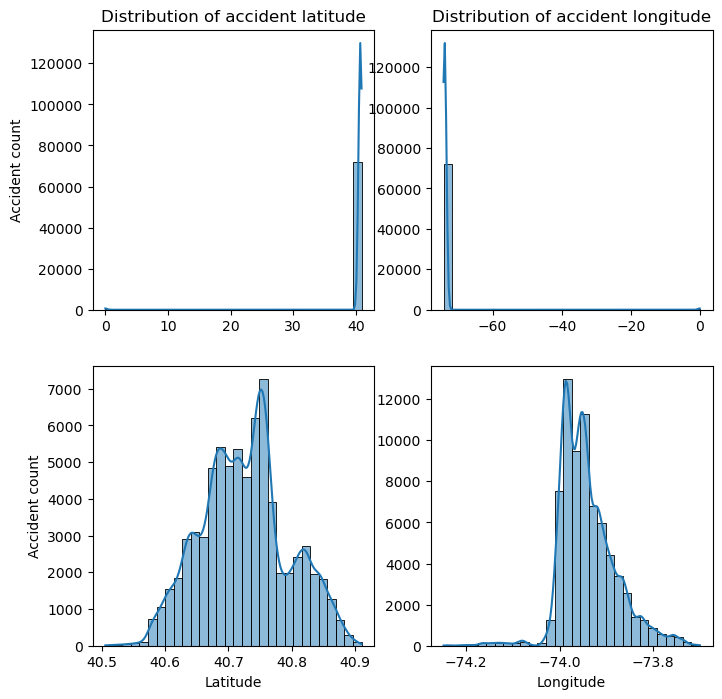

In [79]:
# First, I want to check the distribution of the coordinates

df = df_bike_accidents # select only bike accidents or all accidents (df_accidents)

fig = plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1) # histogram for accident_latitude
sns.histplot(df['accident_latitude'], bins=30, kde=True)
plt.title('Distribution of accident latitude'); plt.xlabel(''); plt.ylabel('Accident count')

plt.subplot(2, 2, 2) # histogram for accident_longitude
sns.histplot(df['accident_longitude'], bins=30, kde=True)
plt.title('Distribution of accident longitude'); plt.xlabel(''); plt.ylabel('')

# I see that there are some outliers (must be incorrect entries) -> remove coordinates outside of NYC
# Approx. corner coordinates of NYC, drawing a square around the city in goodlemaps
corners = np.array([[40.935010, -74.283109],
    [40.937224, -73.682060],
    [40.468978, -73.693787],
    [40.480872, -74.276267]])

df_accidents_filt = df.loc[df['accident_latitude'].between(corners[:,0].min(), corners[:,0].max())]
df_accidents_filt  = df_accidents_filt.loc[df_accidents_filt['accident_longitude'].between(corners[:,1].min(), corners[:,1].max())]

plt.subplot(2, 2, 3) # histogram for accident_latitude (filtered)
sns.histplot(df_accidents_filt['accident_latitude'], bins=30, kde=True)
plt.xlabel('Latitude'); plt.ylabel('Accident count')

plt.subplot(2, 2, 4) # histogram for accident_longitude (filtered)
sns.histplot(df_accidents_filt['accident_longitude'], bins=30, kde=True)
plt.xlabel('Longitude'); plt.ylabel('')

plt.gca().yaxis.set_major_formatter(ScalarFormatter()) # depicting y-values as scientific for clarity
plt.gca().yaxis.get_major_formatter().set_scientific(True)

fig.savefig(os.path.join(results_dir,'accidents_distribution_coordinates.jpg'), format='jpg') # save figure

#plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False)) - set y-value format to default

We can see already that the accident hotspots are around latutude 40.75 and longitude -73.92, which corresponds with the calculated "hotspots_with_coordinates" df. Also, latitude is more or less normally distributed, longitude is not.

In [23]:
# Create a city map with the accident density overlaid
df = df_bike_accidents # select only bike accidents or all accidents (df_accidents)

# remove outliers far outside of NYC
corners = np.array([[40.935010, -74.283109],
    [40.937224, -73.682060],
    [40.468978, -73.693787],
    [40.480872, -74.276267]])

df_accidents_filt = df.loc[df['accident_latitude'].between(corners[:,0].min(), corners[:,0].max())]
df_accidents_filt  = df_accidents_filt.loc[df_accidents_filt['accident_longitude'].between(corners[:,1].min(), corners[:,1].max())]

m_accidents = folium.Map(location=[df_accidents_filt['accident_latitude'].median(), df_accidents_filt['accident_longitude'].median()], zoom_start=10)  
accidents_coords = list(zip(df_accidents_filt['accident_latitude'], df_accidents_filt['accident_longitude']))
HeatMap(accidents_coords, radius=20, blur=25, max_zoom=1).add_to(m_accidents)
#HeatMap(accidents_coords, radius=15, blur=20, max_zoom=1, gradient={0: 'yellow', 0.5: 'orange', 1: 'red'}).add_to(m_accidents)

#from folium import IFrame # notebook works too slow
# title = IFrame('<h3>Accidents Heatmap</h3>', width=200, height=50)
# popup = folium.Popup(title)
# folium.Marker(location=[df_accidents['accident_latitude'].mean(), df_accidents['accident_longitude'].mean()], popup=popup).add_to(m_accidents)

try:
    m_accidents.save(os.path.join(results_dir, 'map_bike_accidents.html')) # save
    print("Map saved successfully!")
except Exception as e:
    print(f"An error occurred: {e}")
    
#m_accidents # show -> makes notebook too big to push to Github repository with Git, so I just save it

del m_accidents # to clear up memory

Map saved successfully!


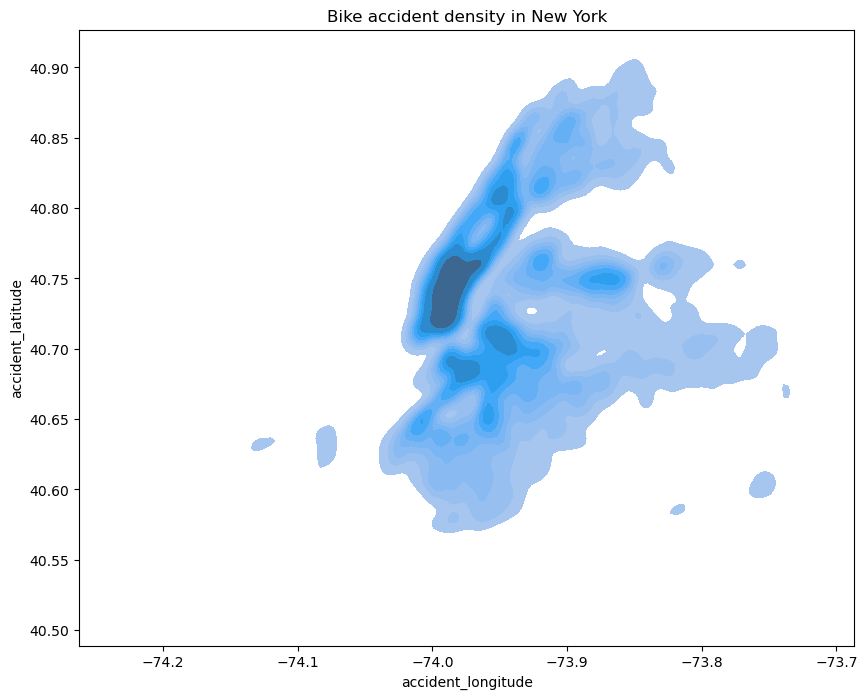

In [95]:
#df_accidents = df_accidents.sort_values(by=['accident_longitude','accident_latitude']) # esle it doesn´t work
df_sample = df_accidents_filt.sample(frac=1)  # take a % of the data for testing
df_sample = df_sample.sort_values(by=['accident_longitude','accident_latitude']) # else it doesn´t work

fig = plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_sample, x='accident_longitude', y='accident_latitude', fill=True, bw_adjust=0.5) #, cmap='Reds', bw_adjust=2
plt.scatter(bike stations)
plt.title('Bike accident density in New York')

fig.savefig(os.path.join(results_dir,'accidents_bikes_density.jpg'), format='jpg') # save figure

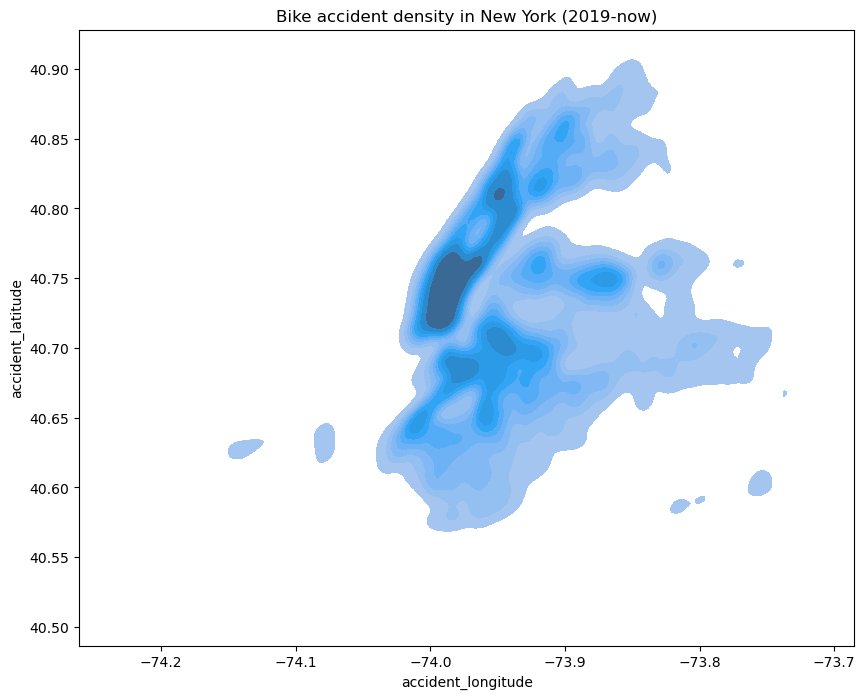

In [98]:
#df_accidents = df_accidents.sort_values(by=['accident_longitude','accident_latitude']) # esle it doesn´t work
df_select = df_accidents_filt.loc[df_accidents_filt['year'] > 2018]

df_sample = df_select.sample(frac=1)  # take 1% of the data for testing
df_sample = df_sample.sort_values(by=['accident_longitude','accident_latitude']) # else it doesn´t work

fig = plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_sample, x='accident_longitude', y='accident_latitude', fill=True, bw_adjust=0.5) #, cmap='Reds', bw_adjust=2
plt.title('Bike accident density in New York (2019-now)')

fig.savefig(os.path.join(results_dir,'accidents_bikes_density2019-now.jpg'), format='jpg') # save figure

Now I will draw a square over NYC in googlemaps and bin the coordinates in 10 by 10, to get the number of accidents per square bin. Later I will do the same using the bike rental station coordinates, to plot a correlation graph.

In [27]:
df = df_bike_accidents # select only bike accidents or all accidents (df_accidents)

df = df.loc[df['year'] > 2018] # filter by year if desired

# remove outliers far outside of NYC
corners = np.array([[40.935010, -74.283109],
    [40.937224, -73.682060],
    [40.468978, -73.693787],
    [40.480872, -74.276267]])

# Extract min and max values for latitude and longitude
min_lat = corners[:,0].min()
max_lat = corners[:,0].max()
min_lon = corners[:,1].min()
max_lon = corners[:,1].max()

num_bins = 50 # create a grid of 10x10 bins
lat_bins = np.linspace(min_lat, max_lat, num_bins + 1)  # Latitude bins
lon_bins = np.linspace(min_lon, max_lon, num_bins + 1)  # Longitude bins

df_accidents_filt = df_accidents.loc[df_accidents['accident_latitude'].between(corners[:,0].min(), corners[:,0].max())]
df_accidents_filt  = df_accidents_filt.loc[df_accidents_filt['accident_longitude'].between(corners[:,1].min(), corners[:,1].max())]

# Bin the latitude and longitude
df_accidents_filt['lat_bin'] = pd.cut(df_accidents_filt['accident_latitude'], bins=lat_bins)
df_accidents_filt['lon_bin'] = pd.cut(df_accidents_filt['accident_longitude'], bins=lon_bins)

# Count the number of accidents in each bin
counts = df_accidents_filt.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')

# Display the counts
print(counts)

count_matrix = counts.pivot_table(index='lat_bin', columns='lon_bin', values='count', fill_value=0) # create a 10x10 matrix (DataFrame) storing the counts

with open(os.path.join(results_dir,'bike_accidents_matrix_50x50_2019-2023.pkl'), 'wb') as f:
    pickle.dump(count_matrix, f)

count_matrix.head() # show

## Another way to do it creating an array
# incident_bins = np.nan(10, 10)
# for x in range(0, 10):
#     for y in range(0, 10):
#         incident_bins[x, y] = coordinates[(coordinates_long >= x) and (coordinates__long < x + 1) and 
#            (coordinates_lat >= y) and (coordinates_y < lat + 1)].count()

               lat_bin             lon_bin  count
0     (40.469, 40.478]  (-74.283, -74.271]      0
1     (40.469, 40.478]  (-74.271, -74.259]      0
2     (40.469, 40.478]  (-74.259, -74.247]      0
3     (40.469, 40.478]  (-74.247, -74.235]      0
4     (40.469, 40.478]  (-74.235, -74.223]      0
...                ...                 ...    ...
2495  (40.928, 40.937]   (-73.742, -73.73]      0
2496  (40.928, 40.937]   (-73.73, -73.718]      0
2497  (40.928, 40.937]  (-73.718, -73.706]      0
2498  (40.928, 40.937]  (-73.706, -73.694]      0
2499  (40.928, 40.937]  (-73.694, -73.682]      0

[2500 rows x 3 columns]


lon_bin,"(-74.283, -74.271]","(-74.271, -74.259]","(-74.259, -74.247]","(-74.247, -74.235]","(-74.235, -74.223]","(-74.223, -74.211]","(-74.211, -74.199]","(-74.199, -74.187]","(-74.187, -74.175]","(-74.175, -74.163]",...,"(-73.802, -73.79]","(-73.79, -73.778]","(-73.778, -73.766]","(-73.766, -73.754]","(-73.754, -73.742]","(-73.742, -73.73]","(-73.73, -73.718]","(-73.718, -73.706]","(-73.706, -73.694]","(-73.694, -73.682]"
lat_bin,,,,,,,,,,,,,,,,,,,,,
"(40.469, 40.478]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(40.478, 40.488]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(40.488, 40.497]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(40.497, 40.506]",0.0,0.0,44.0,219.0,38.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(40.506, 40.516]",0.0,0.0,257.0,607.0,163.0,49.0,110.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


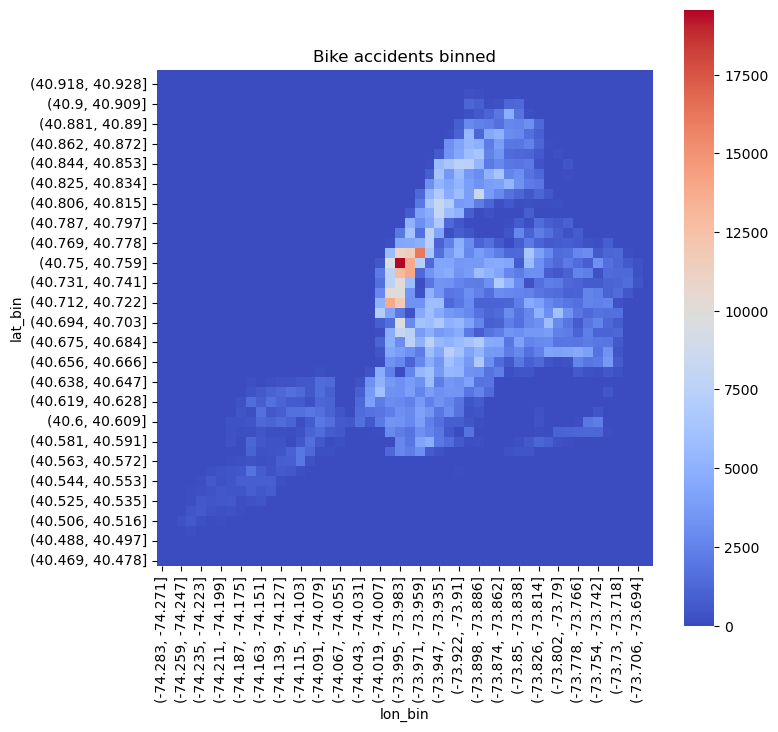

In [49]:
fig = plt.figure(figsize=(8, 8))  # Set the figure size to ensure it's square
sns.heatmap(count_matrix, annot=False, cmap='coolwarm', square=True)  # `square=True` ensures square cells
plt.title("Bike accidents binned")
plt.gca().invert_yaxis()

fig.savefig(os.path.join(results_dir,'bike_accidents_heatmap_binned50x50.jpg',bbox_inches='tight'), format='jpg') # save figure

This looks very similar to the heatmap drawn over the city map!

Same but in 1 km2 bins, by using the following formula:
* Latitude: 1 degree ≈ 110.574 km
* Longitude: 1 degree ≈ 111.320 * cos(latitude) km

lon_bin           (-74.283, -74.271]  (-74.271, -74.259]  (-74.259, -74.248]  \
lat_bin                                                                        
(40.469, 40.478]                 0.0                 0.0                 0.0   
(40.478, 40.487]                 0.0                 0.0                 0.0   
(40.487, 40.496]                 0.0                 0.0                 0.0   
(40.496, 40.505]                 0.0                 0.0                 0.0   
(40.505, 40.514]                 0.0                 0.0                 0.0   

lon_bin           (-74.248, -74.236]  (-74.236, -74.224]  (-74.224, -74.212]  \
lat_bin                                                                        
(40.469, 40.478]                 0.0                 0.0                 0.0   
(40.478, 40.487]                 0.0                 0.0                 0.0   
(40.487, 40.496]                 0.0                 0.0                 0.0   
(40.496, 40.505]                 1.0   

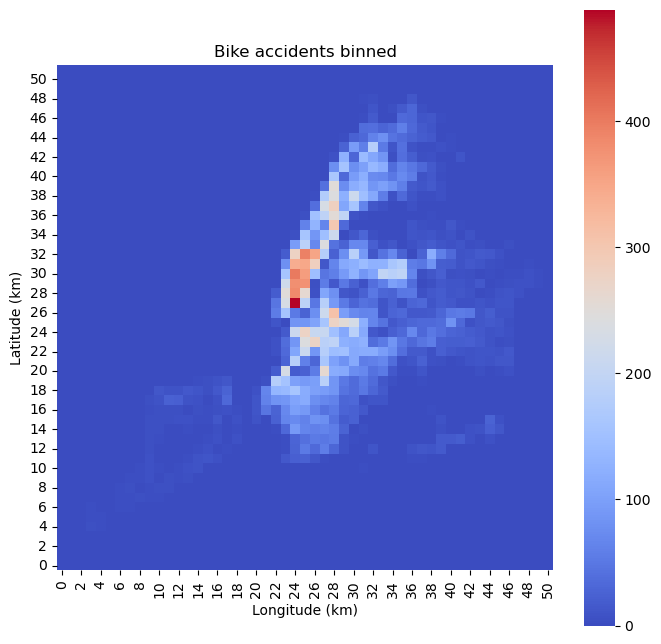

In [29]:
df = df_bike_accidents # select only bike accidents or all accidents (df_accidents)

df = df.loc[df['year'] > 2018] # filter by year if desired

# Constants for converting degrees to km
KM_PER_DEG_LAT = 110.574
def km_per_deg_lon(latitude):
    return 111.320 * np.cos(np.radians(latitude))

bin_size_km = 1  # bin size in square km

# Extract min and max values for latitude and longitude
min_lat = corners[:, 0].min()
max_lat = corners[:, 0].max()
min_lon = corners[:, 1].min()
max_lon = corners[:, 1].max()

# Calculate the number of bins based on bin size (1 km per bin)
# Latitude degrees per km is constant
lat_bin_width_deg = bin_size_km / KM_PER_DEG_LAT
# Longitude degrees per km varies with latitude, so we calculate based on the mean latitude
mean_lat = (min_lat + max_lat) / 2
lon_bin_width_deg = bin_size_km / km_per_deg_lon(mean_lat)

# Generate the latitude and longitude bins
lat_bins = np.arange(min_lat, max_lat + lat_bin_width_deg, lat_bin_width_deg)
lon_bins = np.arange(min_lon, max_lon + lon_bin_width_deg, lon_bin_width_deg)

# Filter accidents data to fall within the corners
df_accidents_filt = df.loc[df['accident_latitude'].between(min_lat, max_lat)]
df_accidents_filt = df_accidents_filt.loc[df_accidents_filt['accident_longitude'].between(min_lon, max_lon)]

# Bin the latitude and longitude
df_accidents_filt['lat_bin'] = pd.cut(df_accidents_filt['accident_latitude'], bins=lat_bins)
df_accidents_filt['lon_bin'] = pd.cut(df_accidents_filt['accident_longitude'], bins=lon_bins)

# Count the number of accidents in each bin
counts = df_accidents_filt.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')

# Create the pivot table (2D matrix)
count_matrix = counts.pivot_table(index='lat_bin', columns='lon_bin', values='count', fill_value=0)

# Save the count matrix as a pickle file
with open(os.path.join(results_dir, 'bike_accidents_matrix_1km_bins.pkl'), 'wb') as f:
    pickle.dump(count_matrix, f)

print(count_matrix.head())

plt.close()
fig = plt.figure(figsize=(8, 8))  # Set the figure size to ensure it's square
ax = sns.heatmap(count_matrix, annot=False, cmap='coolwarm', square=True)  # `square=True` ensures square cells
plt.title("Bike accidents binned")
plt.gca().invert_yaxis()
# Set axis labels to show distances in kilometers
lat_tick_indices = ax.get_yticks().astype(int)
lon_tick_indices = ax.get_xticks().astype(int)

# Calculate the distance corresponding to each tick (km)
lat_km_labels = lat_tick_indices * bin_size_km
lon_km_labels = lon_tick_indices * bin_size_km

# Set the labels for the ticks (km)
ax.set_yticklabels(lat_km_labels)
ax.set_xticklabels(lon_km_labels)

# Set axis labels
ax.set_xlabel("Longitude (km)")
ax.set_ylabel("Latitude (km)")
fig.savefig(os.path.join(results_dir,'bike_accidents_heatmap_binned_km_2019-2023.jpg'), format='jpg') # save figure
plt.show()

# Bike ride data

In [31]:
#df_rides = dd.read_parquet(cleaned_dir + '/combined_dask_df_cleaned.parquet', engine='pyarrow') # 10 GB, instead of 70 GB (raw data)
#ddf = dd.read_parquet(os.path.join(cleaned_dir, 'combined_dask_df1010_cleaned.parquet'), 
#      columns=['start_datetime','birth_year', 'gender','user_type','trip_duration','year','month']) # read only specific columns, to reduce needed memory

filters = [('year', 'in', [2019, 2020, 2021, 2022, 2023])] # filters = [('year', 'in', [2916, 2023]), ('month', '=', 5)] # [('year', '=', 2023)]
columns_to_load = ['start_datetime','end_datetime','year','month','birth_year', 'gender','user_type','trip_duration','rideable_type']  # Replace with your actual column names
ddf = dd.read_parquet(os.path.join(cleaned_dir_bike_rides,'combined_dask_df0610_cleaned.parquet'), 
                                   columns=columns_to_load) # read only specific partition and selected columns -filters=filters, 

# sample data, for faster processing
# ddf = dd.read_parquet(os.path.join(cleaned_dir, 'df_rides_sampled.parquet'), engine='pyarrow') # 4GB, older version
# print('ddf loaded')
# #ddf = ddf.set_index('start_datetime') # for faster computations
# ddf = ddf.repartition(partition_size="500MB") # 
# ddf = ddf.sample(frac=0.1).persist() # Accident data=500MB which is fine, so further reduce 10x to be able to smoothly test the code
# print('ddf downsampled and persisted'); 
print('Number of rows in dataset: \n'); print(ddf['start_datetime'].shape[0].compute()) # number of rows in dataset
print('Dtypes per column: \n'); print(ddf.dtypes)
ddf.head()

Number of rows in dataset: 

124978620
Dtypes per column: 

start_datetime    datetime64[us]
end_datetime      datetime64[us]
year                    category
month                   category
birth_year                 int32
gender                  category
user_type               category
trip_duration              int32
rideable_type           category
dtype: object


,start_datetime,end_datetime,year,month,birth_year,gender,user_type,trip_duration,rideable_type
0,2013-06-01 00:00:01,2013-06-01 00:11:36,2013,6,1983,NaN,member,695,NaN
1,2013-06-01 00:00:08,2013-06-01 00:11:41,2013,6,1984,NaN,member,693,NaN
2,2013-06-01 00:00:44,2013-06-01 00:35:03,2013,6,0,NaN,casual,2059,NaN
3,2013-06-01 00:01:04,2013-06-01 00:03:07,2013,6,1960,NaN,member,123,NaN
4,2013-06-01 00:01:22,2013-06-01 00:26:43,2013,6,1983,NaN,member,1521,NaN


In [33]:
print('Number of NaNs per column:')
ddf.isna().sum().compute()

Number of NaNs per column:


start_datetime                  0
end_datetime                    0
year                            0
month                           0
birth_year                      0
gender                  124978620
user_type                   52277
trip_duration                   0
rideable_type            93650134
age                             0
age_group                37701927
trip_duration_m                 0
trip_duration_h                 0
trip_duration_h_corr            0
hour                            0
dtype: int64

In [158]:
# check memory usage
memory_usage = ddf.memory_usage(deep=True).compute()
total_memory_usage = memory_usage.sum()
print(f"Total memory usage: {total_memory_usage / (1024**3):.2f} GB")

Total memory usage: 4.27 GB


### Are there specific groups that rent more bikes (grouped by gender and age, or user type)?

Insights into who rents the most bikes (number of rentals and total trip duration), and could therefore be more vulnarable to accidents
* trip duration per group: bike_user member vs casual, gender and age


Some data manipulations for plotting of age groups, bike ride duration per hour, and calculating trip_duration from start_datetime and end_datetime as a correction for it sometimes being 0.

In [32]:
# Data formatting

# add age groups
ddf['age'] = 2024 - ddf['birth_year']
# # Group age in 10 year periods; 5-15, 15-25 etc (remember that I set NaNs in birth_year to 0, as 2024-year olds do not exist)
ddf['age_group'] = ddf['age'].map_partitions(pd.cut, bins=range(5, 95, 9), right=False, labels=[f'{i}-{i+9}' for i in range(5, 95, 10)])

# add trip_duration in minutes and hours
ddf['trip_duration_m'] = ddf['trip_duration'] / 60 # calculate trip duration in minutes
ddf['trip_duration_h'] = ddf['trip_duration'] / 3600 # calculate trip duration in hours
ddf['trip_duration_h_corr'] = (ddf['end_datetime'] - ddf['start_datetime']).dt.total_seconds() / 3600 # I noticed that some trip_duration entries are 0 (incorrectly)
ddf['trip_duration_m'] = ddf['trip_duration_m'].round(2); ddf['trip_duration_h'] = ddf['trip_duration_h'].round(2); 
ddf['trip_duration_h_corr'] = ddf['trip_duration_h_corr'].round(2);

# add hour for hourly plotting
ddf['hour'] = ddf['start_datetime'].dt.hour
ddf = ddf.sort_values(by=['month','year'])
ddf.head(1)

,start_datetime,end_datetime,year,month,birth_year,gender,user_type,trip_duration,rideable_type,age,age_group,trip_duration_m,trip_duration_h,trip_duration_h_corr,hour
0,2014-01-01 00:00:06,2014-01-01 00:07:57,2014,1,1986,NaN,member,471,NaN,38,35-44,7.85,0.13,0.13,0


### 1. Age

     year  month age_group  trip_duration_h_corr
0    2013      1      5-14                   0.0
1    2013      1     15-24                   0.0
2    2013      1     25-34                   0.0
3    2013      1     35-44                   0.0
4    2013      1     45-54                   0.0
..    ...    ...       ...                   ...
967  2021     12     45-54                   0.0
968  2021     12     55-64                   0.0
969  2021     12     65-74                   0.0
970  2021     12     75-84                   0.0
971  2021     12     85-94                   0.0

[972 rows x 4 columns]
0     2013-01-01
1     2013-01-01
2     2013-01-01
3     2013-01-01
4     2013-01-01
         ...    
967   2021-12-01
968   2021-12-01
969   2021-12-01
970   2021-12-01
971   2021-12-01
Name: date, Length: 972, dtype: datetime64[ns]
     year  month age_group  trip_duration_h_corr       date
0    2013      1      5-14                   0.0 2013-01-01
9    2013      2      5-14        

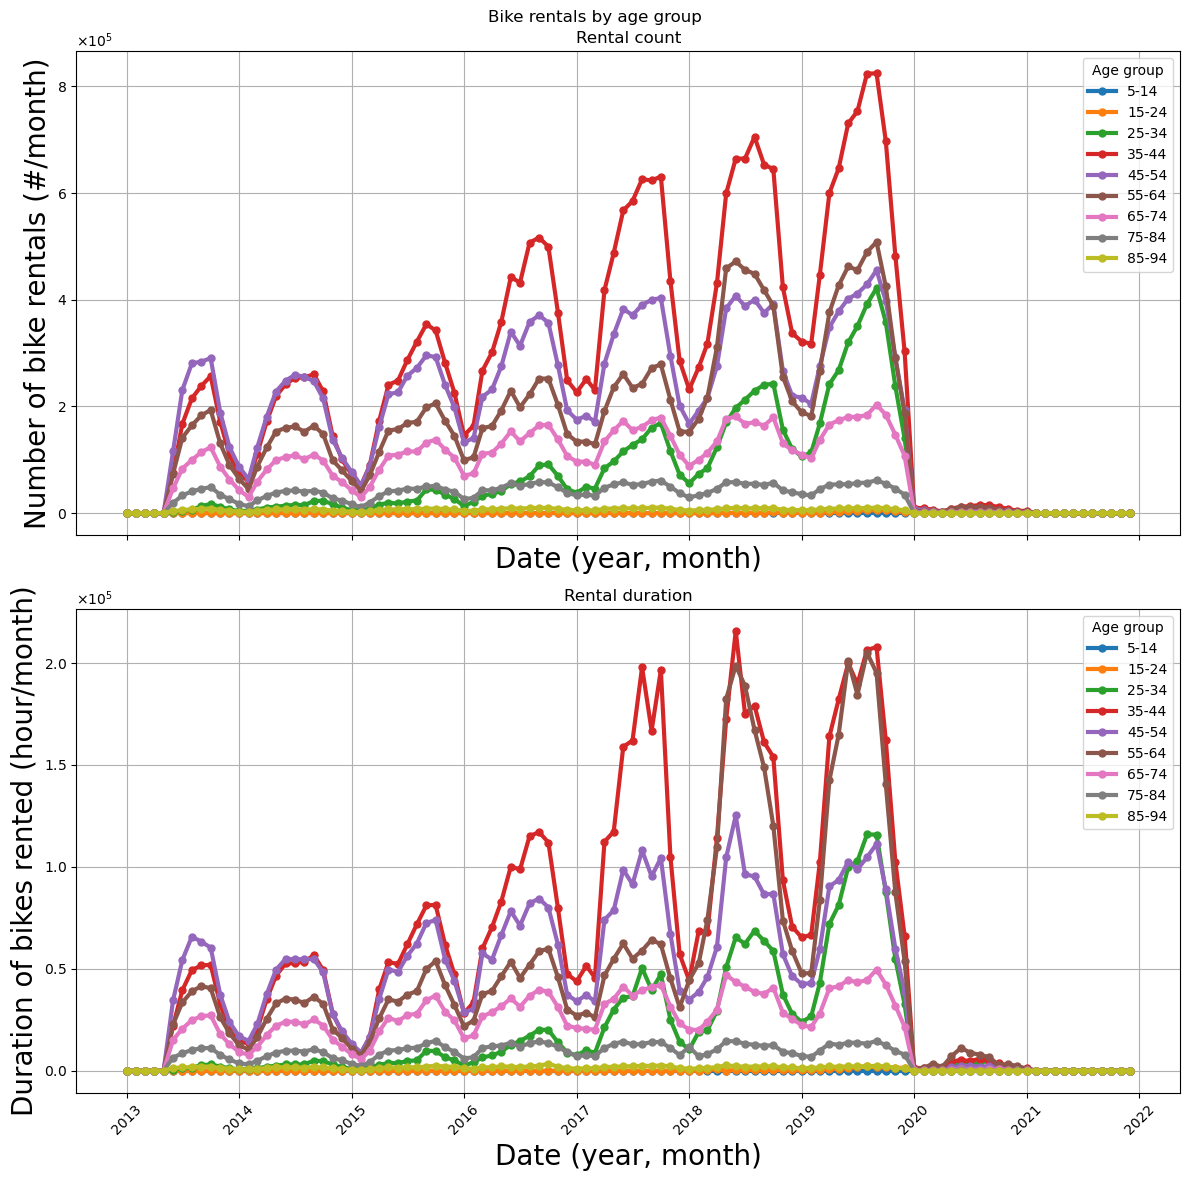

In [21]:
# by AGE GROUP - plot (all years)

variable = 'trip_duration_h_corr'
group_by = 'age_group'
xy_labels = [['Date (year, month)','Date (year, month)'],['Number of bike rentals (#/month)', 'Duration of bikes rented (hour/month)']]
plot_title = 'Bike rentals by age group'
save_name = os.path.join(results_dir, 'bike_rentals_age.jpg')

ddf_plot_grouped_timeline(ddf, variable, group_by, xy_labels, plot_title, save_name)

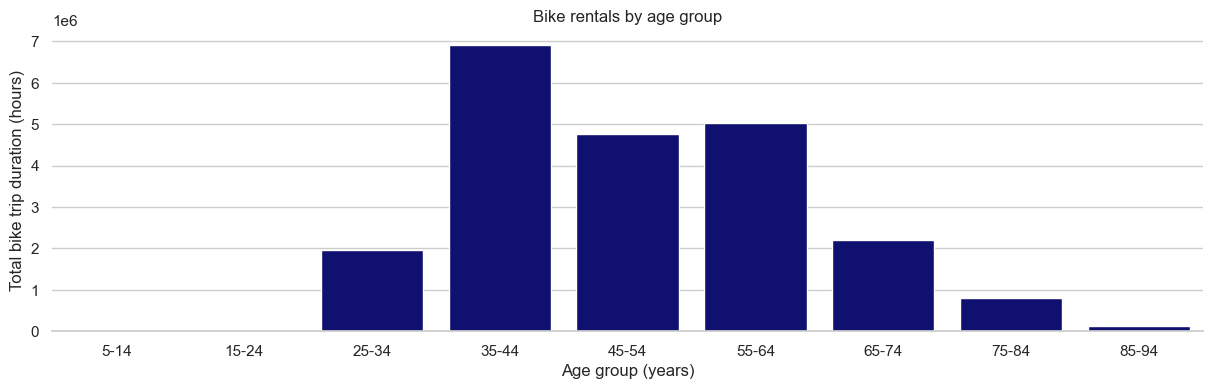

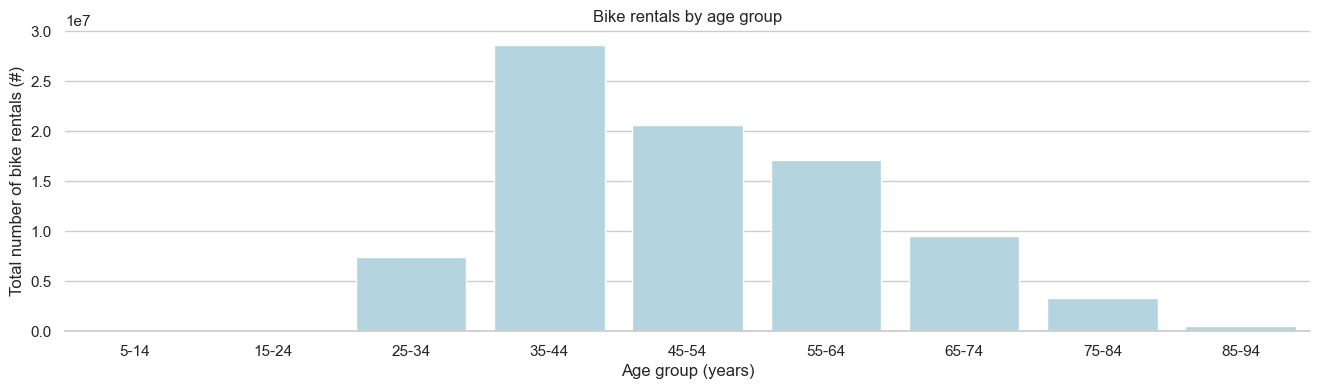

In [76]:
variable = 'trip_duration_h_corr'
group_by = 'age_group'
xy_labels = ['Age group (years)', 'Total bike trip duration (hours)']
plot_title = 'Bike rentals by age group'
save_name = os.path.join(results_dir, 'bike_rentals_age_duration_barplot.jpg')

plot_grouped_ride_duration_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)
# filter_years = [2019,2023]
# plot_grouped_ride_duration_bars(ddf, variable, group_by, xy_labels, plot_title, save_name, filter_years)

variable = 'trip_duration_h_corr'
group_by = 'age_group'
xy_labels = ['Age group (years)', 'Total number of bike rentals (#)']
plot_title = 'Bike rentals by age group'
save_name = os.path.join(results_dir, 'bike_rentals_age_count_barplot.jpg')

plot_grouped_ride_count_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)

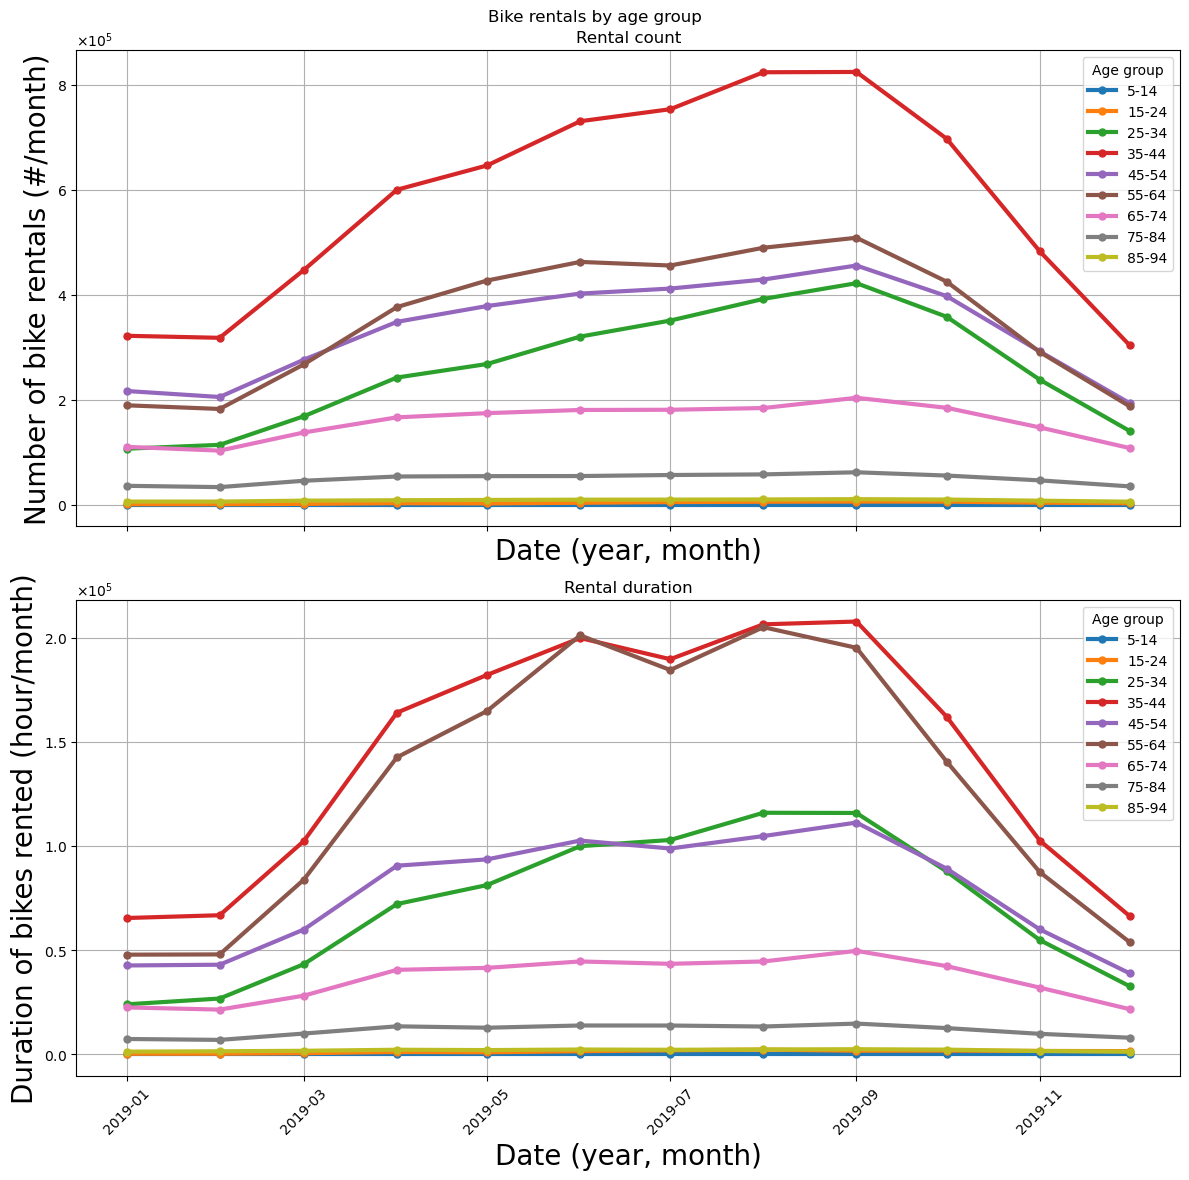

In [28]:
# Separate plot, as ddf_plot_grouped_timeline() was plotting on the x-axis the whole period 2019-2023 (all 0's)

variable = 'trip_duration_h_corr'
group_by = 'age_group'
xy_labels = [['Date (year, month)','Date (year, month)'],['Number of bike rentals (#/month)', 'Duration of bikes rented (hour/month)']]
plot_title = 'Bike rentals by age group'
save_name = os.path.join(results_dir, 'bike_rentals_age_2019.jpg')

ddf = ddf.dropna(subset=[variable, group_by]) # drop all rows where variable is NaN 
ddf = ddf.sort_values('start_datetime')
ddf['year'] = ddf['start_datetime'].dt.year

bike_rides_number_month = ( # Calculate the count for each month
    ddf.groupby(['year','month', group_by])[variable]
    .count().reset_index().compute()
)
bike_rides_sum_month = ( # Calculate the sum for each month
    ddf.groupby(['year','month', group_by])[variable]
    .sum().reset_index().compute()
)

bike_rides_number_month['date'] = pd.to_datetime(bike_rides_number_month[['year','month']].assign(day=1))
bike_rides_sum_month['date'] = pd.to_datetime(bike_rides_sum_month[['year','month']].assign(day=1))

formatter = ScalarFormatter(useMathText=True) # adjust power limits to enforce scientific notation
formatter.set_scientific(True)
formatter.set_powerlimits((0, 4))  

plt.close()
fig, axes = plt.subplots(2,1, figsize=(12, 12), sharex=True); axes = axes.flatten();
plt.suptitle(plot_title)

unique_groups = bike_rides_number_month[group_by].unique()
for group in unique_groups:
    group_data_count = bike_rides_number_month[bike_rides_number_month[group_by] == group]
    group_data_sum = bike_rides_sum_month[bike_rides_sum_month[group_by] == group]

    # Plot the count per group
    axes[0].plot(group_data_count['date'], group_data_count[variable], marker='o', linewidth=3, markersize=5, label=f'{group}')

    # Plot the sum per group
    axes[1].plot(group_data_sum['date'], group_data_sum[variable], marker='o', linewidth=3, markersize=5, label=f'{group}')

#axes[0].plot(bike_rides_number_month['date'], bike_rides_number_month[variable], marker='o', color=label_colours_dict[var], label='count')
axes[0].set_xlabel(xy_labels[0][0])
axes[0].set_ylabel(xy_labels[1][0])
axes[0].set_title('Rental count')
axes[0].yaxis.set_major_formatter(formatter) # format y-values as scientific for better readability
axes[0].tick_params(axis='x', rotation=45)
#axes[0].set_xlim([])
axes[0].grid()
axes[0].legend(title='Age group')

#axes[1].plot(bike_rides_sum_month['date'], bike_rides_sum_month[variable], marker='o', color=label_colours_dict[var], label='count')
axes[1].set_xlabel(xy_labels[0][1])
axes[1].set_ylabel(xy_labels[1][1])
axes[1].set_title('Rental duration')
axes[1].yaxis.set_major_formatter(formatter) # format y-values as scientific for better readability
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid()
axes[1].legend(title='Age group')
plt.tight_layout()

fig.savefig(save_name, format='jpg') # save figure
plt.show()


After 2019, there is no data about age (birth_year column missing). So, now I will take only the year 2019 (most recent year with information) to have a closer look at age groups.

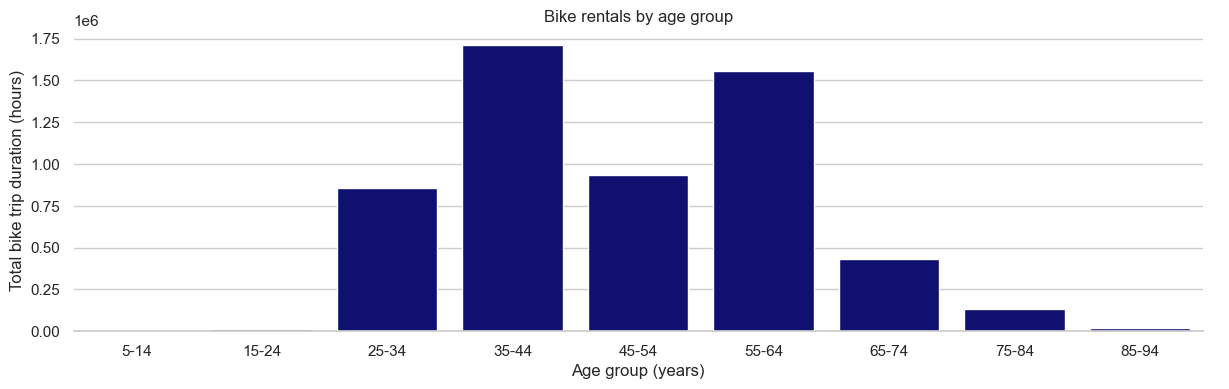

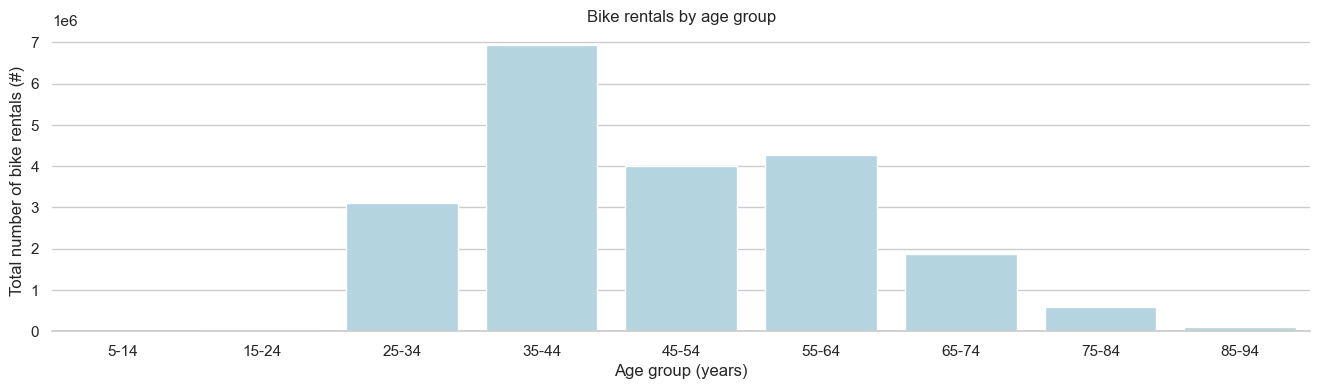

In [14]:
# bar plots, 2019 only

variable = 'trip_duration_h_corr'
group_by = 'age_group'
xy_labels = ['Age group (years)', 'Total bike trip duration (hours)']
plot_title = 'Bike rentals by age group'
save_name = os.path.join(results_dir, 'bike_rentals_age_duration_barplot2019.jpg')

plot_grouped_ride_duration_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)
# filter_years = [2019,2023]
# plot_grouped_ride_duration_bars(ddf, variable, group_by, xy_labels, plot_title, save_name, filter_years)

variable = 'trip_duration_h_corr'
group_by = 'age_group'
xy_labels = ['Age group (years)', 'Total number of bike rentals (#)']
plot_title = 'Bike rentals by age group'
save_name = os.path.join(results_dir, 'bike_rentals_age_count_barplot2019.jpg')

plot_grouped_ride_count_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)

### 2. User type

In [4]:
filters = [('year', '=', 2023)] # [('year', 'in', [2019, 2020, 2021, 2022, 2023])] # filters = [('year', 'in', [2916, 2023]), ('month', '=', 5)] # [('year', '=', 2023)]
columns_to_load = ['start_datetime','end_datetime','year','month','birth_year', 'gender','user_type','trip_duration','rideable_type']  # Replace with your actual column names
ddf = dd.read_parquet(os.path.join(cleaned_dir_bike_rides,'combined_dask_df0610_cleaned.parquet'), 
                                   columns=columns_to_load) #filters=filters,
print('Number of rows in dataset: \n'); print(ddf['start_datetime'].shape[0].compute()) # number of rows in dataset
print('Dtypes per column: \n'); print(ddf.dtypes)
ddf.head()

Number of rows in dataset: 

124978620
Dtypes per column: 

start_datetime    datetime64[us]
end_datetime      datetime64[us]
year                    category
month                   category
birth_year                 int32
gender                  category
user_type               category
trip_duration              int32
rideable_type           category
dtype: object


,start_datetime,end_datetime,year,month,birth_year,gender,user_type,trip_duration,rideable_type
0,2013-06-01 00:00:01,2013-06-01 00:11:36,2013,6,1983,NaN,member,695,NaN
1,2013-06-01 00:00:08,2013-06-01 00:11:41,2013,6,1984,NaN,member,693,NaN
2,2013-06-01 00:00:44,2013-06-01 00:35:03,2013,6,0,NaN,casual,2059,NaN
3,2013-06-01 00:01:04,2013-06-01 00:03:07,2013,6,1960,NaN,member,123,NaN
4,2013-06-01 00:01:22,2013-06-01 00:26:43,2013,6,1983,NaN,member,1521,NaN


In [5]:
# Data formatting

# add age groups
ddf['age'] = 2024 - ddf['birth_year']
# # Group age in 10 year periods; 5-15, 15-25 etc (remember that I set NaNs in birth_year to 0, as 2024-year olds do not exist)
ddf['age_group'] = ddf['age'].map_partitions(pd.cut, bins=range(5, 95, 9), right=False, labels=[f'{i}-{i+9}' for i in range(5, 95, 10)])

# add trip_duration in minutes and hours
ddf['trip_duration_m'] = ddf['trip_duration'] / 60 # calculate trip duration in minutes
ddf['trip_duration_h'] = ddf['trip_duration'] / 3600 # calculate trip duration in hours
ddf['trip_duration_h_corr'] = (ddf['end_datetime'] - ddf['start_datetime']).dt.total_seconds() / 3600 # I noticed that some trip_duration entries are 0 (incorrectly)
ddf['trip_duration_m'] = ddf['trip_duration_m'].round(2); ddf['trip_duration_h'] = ddf['trip_duration_h'].round(2); 
ddf['trip_duration_h_corr'] = ddf['trip_duration_h_corr'].round(2);

# add hour for hourly plotting
ddf['hour'] = ddf['start_datetime'].dt.hour
ddf = ddf.sort_values(by=['month','year'])
ddf.head(1)

,start_datetime,end_datetime,year,month,birth_year,gender,user_type,trip_duration,rideable_type,age,age_group,trip_duration_m,trip_duration_h,trip_duration_h_corr,hour
0,2014-01-01 00:00:06,2014-01-01 00:07:57,2014,1,1986,NaN,member,471,NaN,38,35-44,7.85,0.13,0.13,0


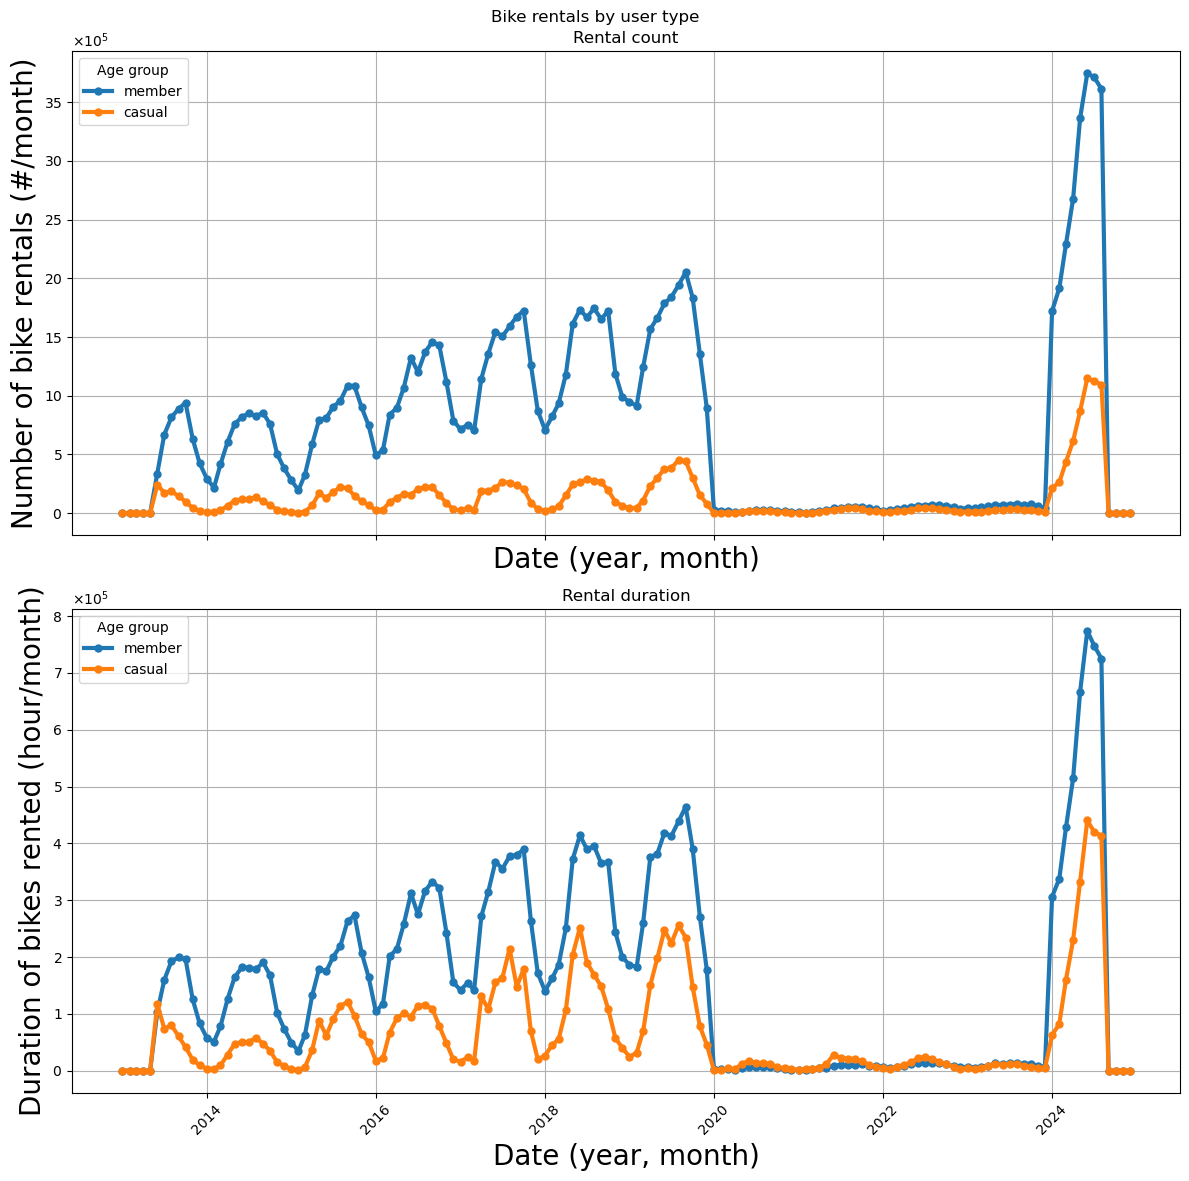

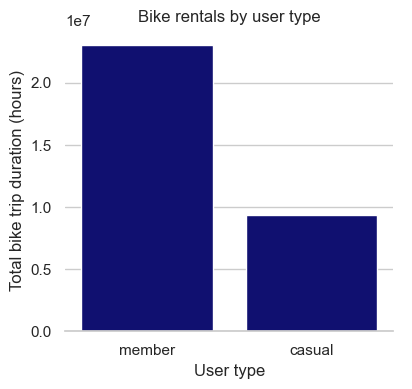

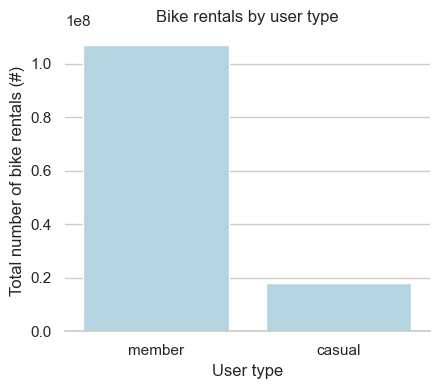

In [23]:
# by USER TYPE 
variable = 'trip_duration_h_corr'
group_by = 'user_type'
xy_labels = [['Date (year, month)','Date (year, month)'],['Number of bike rentals (#/month)', 'Duration of bikes rented (hour/month)']]
plot_title = 'Bike rentals by user type'
save_name = os.path.join(results_dir, 'bike_rentals_user-type.jpg')

ddf_plot_grouped_timeline(ddf, variable, group_by, xy_labels, plot_title, save_name)

variable = 'trip_duration_h_corr'
group_by = 'user_type'
xy_labels = ['User type', 'Total bike trip duration (hours)']
plot_title = 'Bike rentals by user type'
save_name = os.path.join(results_dir, 'bike_rentals_user-type_barplot.jpg')

plot_grouped_ride_duration_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)
# filter_years = [2019,2023]
# plot_grouped_ride_duration_bars(ddf, variable, group_by, xy_labels, plot_title, save_name, filter_years)

variable = 'trip_duration_h_corr'
group_by = 'user_type'
xy_labels = ['User type', 'Total number of bike rentals (#)']
plot_title = 'Bike rentals by user type'
save_name = os.path.join(results_dir, 'bike_rentals_user-type_count_barplot.jpg')

plot_grouped_ride_count_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)

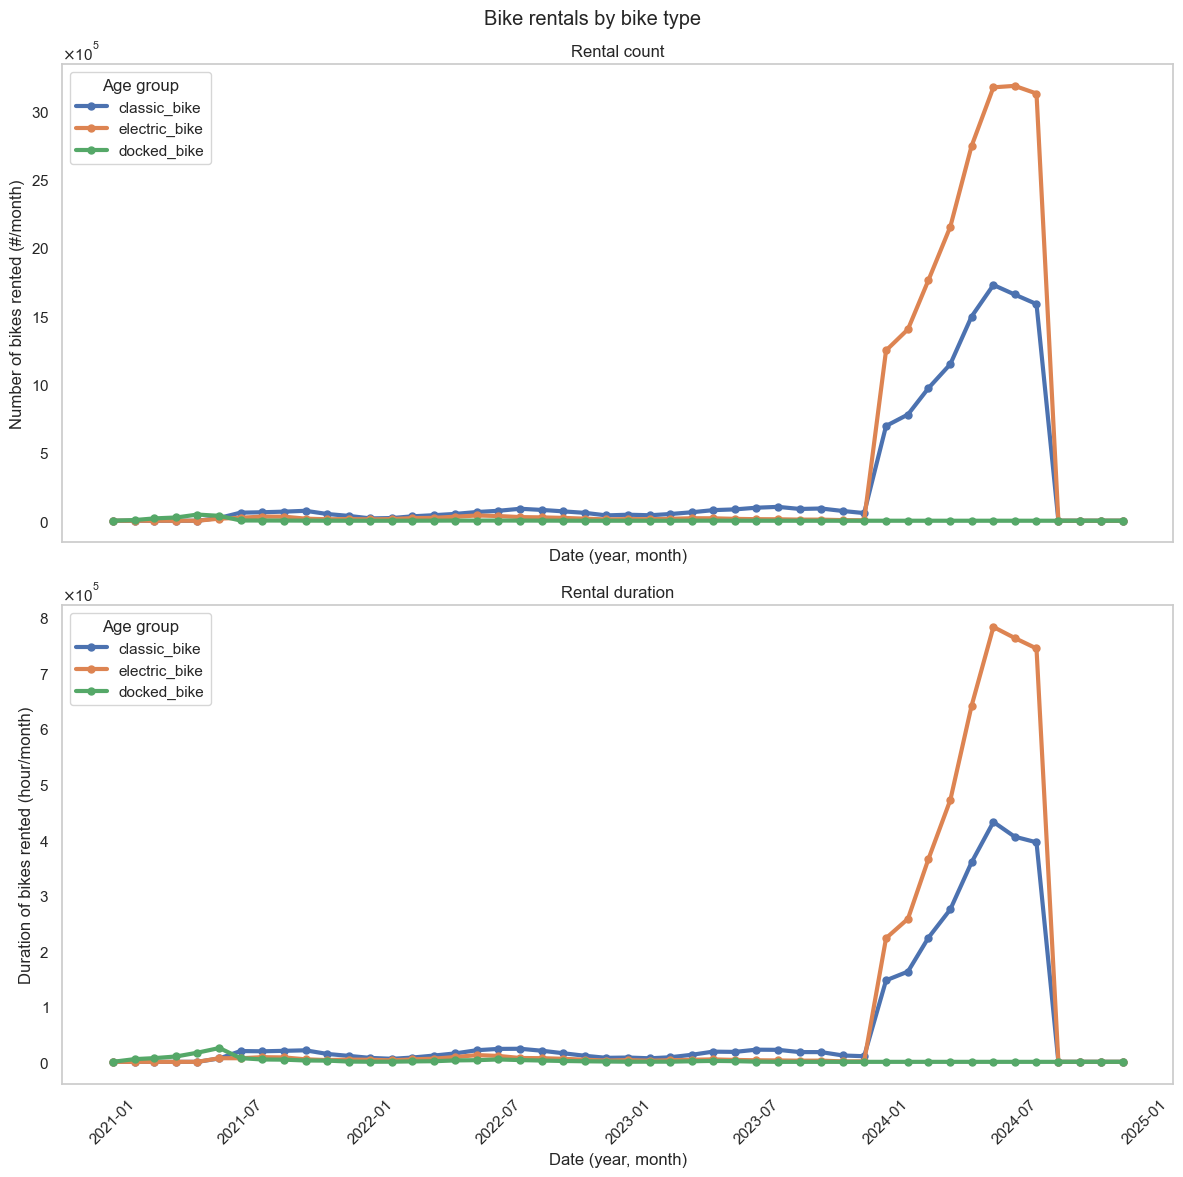

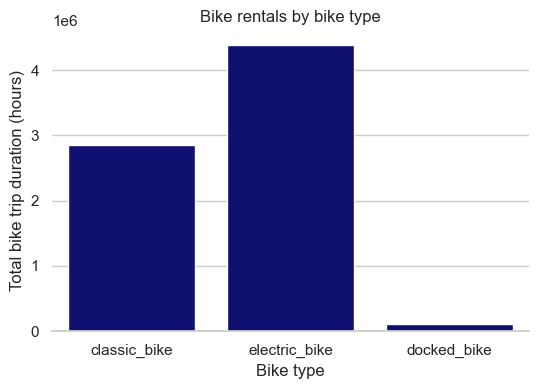

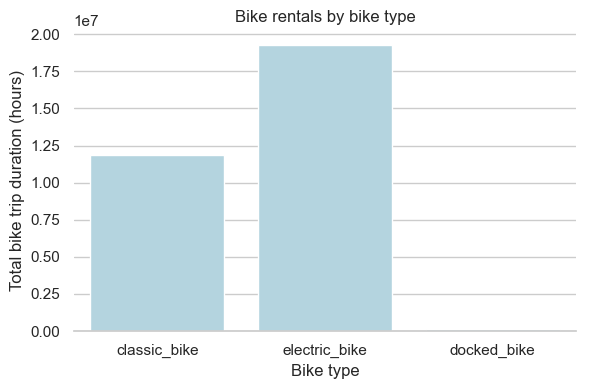

In [24]:
# by BIKE TYPE 
variable = 'trip_duration_h_corr'
group_by = 'rideable_type'
xy_labels = [['Date (year, month)','Date (year, month)'],['Number of bikes rented (#/month)', 'Duration of bikes rented (hour/month)']]
plot_title = 'Bike rentals by bike type'
save_name = os.path.join(results_dir, 'bike_rentals_bike-type.jpg')

ddf_plot_grouped_timeline(ddf, variable, group_by, xy_labels, plot_title, save_name)

variable = 'trip_duration_h_corr'
group_by = 'rideable_type'
xy_labels = ['Bike type', 'Total bike trip duration (hours)']
plot_title = 'Bike rentals by bike type'
save_name = os.path.join(results_dir, 'bike_rentals_bike-type_duration_barplot.jpg')

plot_grouped_ride_duration_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)

variable = 'trip_duration_h_corr'
group_by = 'rideable_type'
xy_labels = ['Bike type', 'Total bike trip duration (hours)']
plot_title = 'Bike rentals by bike type'
save_name = os.path.join(results_dir, 'bike_rentals_bike-type_count_barplot.jpg')

plot_grouped_ride_count_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)

In [ ]:
# by GENDER - unfortunately, something went wrong when setting the global categories to the gender column and all entries are nan (needs correction)
variable = 'trip_duration_h_corr'
group_by = 'gender'
xy_labels = [['Date (year, month)','Date (year, month)'],['Number of bikes rented (#/month)', 'Duration of bikes rented (hour/month)']]
plot_title = 'Bike rentals by gender'
save_name = os.path.join(results_dir, 'bike_rentals_gender.jpg')

plot_grouped_timeline(ddf, variable, group_by, xy_labels, plot_title, save_name)

variable = 'trip_duration_h_corr'
group_by = 'gender'
xy_labels = ['Gender', 'Total bike trip duration (hours)']
plot_title = 'Bike rentals by gender'
save_name = os.path.join(results_dir, 'bike_rentals_gender_duration_barplot.jpg')

plot_grouped_ride_duration_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)

variable = 'trip_duration_h_corr'
group_by = 'gender'
xy_labels = ['ender', 'Total bike trip duration (hours)']
plot_title = 'Bike rentals by gender'
save_name = os.path.join(results_dir, 'bike_rentals_gender_count_barplot.jpg')

plot_grouped_ride_count_bars(ddf, variable, group_by, xy_labels, plot_title, save_name)

Also, which time of the dayare there most bike rides?

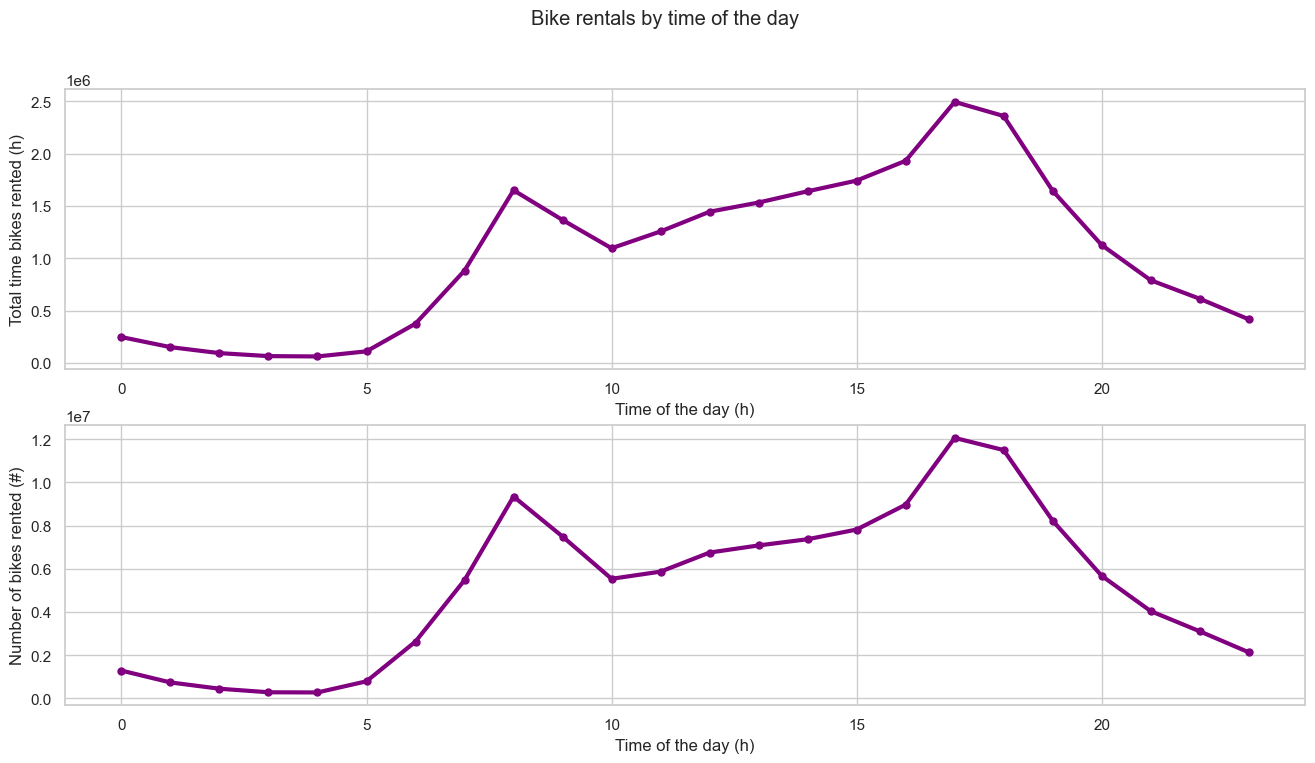

In [37]:
# by HOUR

#select_years = (2019,2023)
#ddf=ddf.loc[ddf['year'].between(select_years)]
    
df_sum, df_count = get_ddf_sum_and_count(ddf,'trip_duration_h','hour')

plt.close()
fig, axes = plt.subplots(2, 1, figsize=(16, 8)); axes = axes.flatten()
plt.suptitle(f'Bike rentals by time of the day') #({select_years[0]}-{select_years[1]})
# Total bike trip duration
axes[0].plot(df_sum['hour'],df_sum['trip_duration_h'], marker='o', linewidth=3, markersize=5, color='purple')
axes[0].set_xlabel('Time of the day (h)'); axes[0].set_ylabel('Total time bikes rented (h)');
# Bike trip count
axes[1].plot(df_count['hour'],df_count['trip_duration_h'], marker='o', linewidth=3, markersize=5, color='purple')
axes[1].set_xlabel('Time of the day (h)'); axes[1].set_ylabel('Number of bikes rented (#)');
plt.show()

fig.savefig(os.path.join(results_dir,'bike_rides_per_hour.jpg'), format='jpg') # save figure

# Heatmaps of bike rentals and collisions (latitude & longitude)

### Load coordinates of bike rides

In [38]:
filters = [('year', 'in', [2019,2020,2021,2022,2023])] #filters = [('year', '=', 2023)] # filters = [('year', 'in', [2016, 2023]), ('month', '=', 5)] # [('year', '=', 2023)]
columns_to_load = ['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']  
ddf = dd.read_parquet(os.path.join(cleaned_dir_bike_rides,'combined_dask_df0610_cleaned.parquet'), 
                                   filters=filters, columns=columns_to_load) # read only specific partition and selected columns

print('Number of rows in dataset: \n'); print(ddf['start_station_latitude'].shape[0].compute()) # number of rows in dataset
print('Dtypes per column: \n'); print(ddf.dtypes); print(ddf.isna().sum().compute())
ddf = ddf.dropna()
print(ddf.isna().sum().compute())
ddf.head()

Number of rows in dataset: 

23809184
Dtypes per column: 

start_station_latitude     float32
start_station_longitude    float32
end_station_latitude       float32
end_station_longitude      float32
dtype: object
start_station_latitude        0
start_station_longitude       0
end_station_latitude       5188
end_station_longitude      5188
dtype: int64
start_station_latitude     0
start_station_longitude    0
end_station_latitude       0
end_station_longitude      0
dtype: int64


,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,40.778969,-73.973747,40.788219,-73.970413
1,40.751873,-73.977707,40.747803,-73.973442
2,40.785248,-73.976677,40.773144,-73.958565
3,40.732220,-73.981659,40.738045,-73.996429
4,40.727436,-73.993790,40.738274,-73.987518


In [39]:
# drop missing values and concatenate start and end station coordinates

df_rides_loc = ddf.compute()

print(df_rides_loc.head(2))
print(df_rides_loc.shape)

#df_accidents = df_accidents.dropna(subset=['accident_latitude', 'accident_longitude'], axis=0) 

# Concatenate latitude and longitude start+stop bike station
bike_station_coord = pd.DataFrame(columns=['station_latitude','station_longitude'])
bike_station_coord['station_latitude'] = pd.concat([df_rides_loc['start_station_latitude'],df_rides_loc['end_station_latitude']])
bike_station_coord['station_longitude'] = pd.concat([df_rides_loc['start_station_longitude'],df_rides_loc['end_station_longitude']])

print(bike_station_coord.head(2)) # check
print(bike_station_coord.shape)

   start_station_latitude  start_station_longitude  end_station_latitude  \
0               40.778969               -73.973747             40.788219   
1               40.751873               -73.977707             40.747803   

   end_station_longitude  
0             -73.970413  
1             -73.973442  
(23803996, 4)
   station_latitude  station_longitude
0         40.778969         -73.973747
1         40.751873         -73.977707
(47607992, 2)


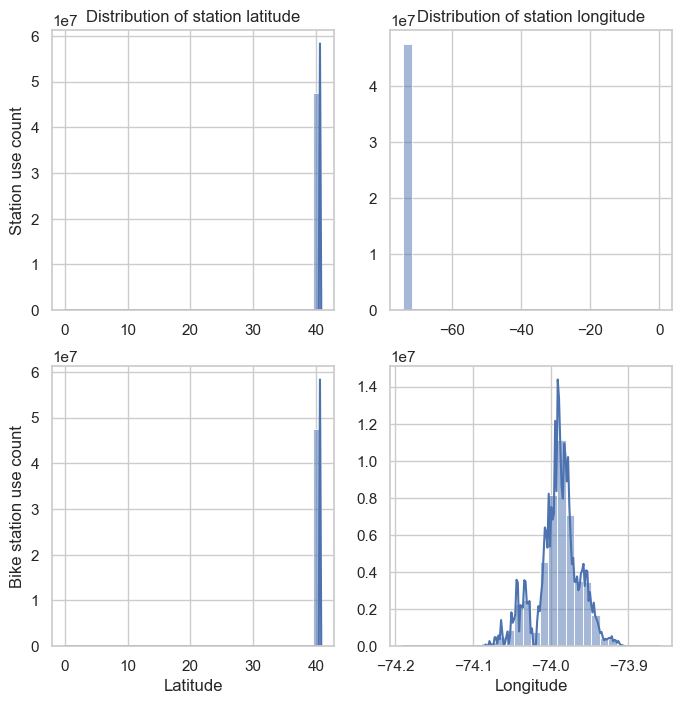

In [40]:
# First, I want to check the distribution of the coordinates

bike_station_coord = bike_station_coord.sort_values(by=['station_latitude','station_longitude'])

fig = plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1) # histogram for station_latitude
sns.histplot(bike_station_coord['station_latitude'], bins=30, kde=True)
plt.title('Distribution of station latitude'); plt.xlabel(''); plt.ylabel('Station use count')

plt.subplot(2, 2, 2) # histogram for station_longitude
sns.histplot(bike_station_coord['station_longitude'], bins=30, kde=True)
plt.title('Distribution of station longitude'); plt.xlabel(''); plt.ylabel('')

# I see that there are some outliers (must be incorrect entries) -> remove coordinates outside of NYC
# Approx. corner coordinates of NYC, drawing a square around the city in goodlemaps
corners = np.array([[40.935010, -74.283109],
    [40.937224, -73.682060],
    [40.468978, -73.693787],
    [40.480872, -74.276267]])

plt.subplot(2, 2, 3) # histogram for station_latitude (filtered)
sns.histplot(bike_station_coord['station_latitude'], bins=30, kde=True)
plt.xlabel('Latitude'); plt.ylabel('Bike station use count')

bike_station_coord = bike_station_coord.loc[bike_station_coord['station_latitude'].between(corners[:,0].min(), corners[:,0].max())]
bike_station_coord  = bike_station_coord.loc[bike_station_coord['station_longitude'].between(corners[:,1].min(), corners[:,1].max())]

plt.subplot(2, 2, 4) # histogram for accident_longitude (filtered)
sns.histplot(bike_station_coord['station_longitude'], bins=30, kde=True)
plt.xlabel('Longitude'); plt.ylabel('')

plt.gca().yaxis.set_major_formatter(ScalarFormatter()) # depicting y-values as scientific for clarity
plt.gca().yaxis.get_major_formatter().set_scientific(True)

fig.savefig(os.path.join(results_dir,'bike-stations_distribution_coordinates2019-2023.jpg'), format='jpg') # save figure
plt.show()

In [7]:
df_accidents = pd.read_csv(cleaned_dir + '/collisions_cleaned.csv')

# remove coordinates entirely outside of NY

# Filter out NaN values in coordinates
df_accidents = df_accidents.dropna(subset=['accident_latitude', 'accident_longitude'])
# Filter out invalid or out-of-range coordinates
df_accidents = df_accidents[(df_accidents['accident_latitude'] > -90) & (df_accidents['accident_latitude'] < 90)]
df_accidents = df_accidents[(df_accidents['accident_longitude'] > -180) & (df_accidents['accident_longitude'] < 180)]

corners = np.array([[40.935010, -74.283109],
    [40.937224, -73.682060],
    [40.468978, -73.693787],
    [40.480872, -74.276267]])

df_accidents = df_accidents.loc[df_accidents['accident_latitude'].between(corners[:,0].min(), corners[:,0].max())]
df_accidents  = df_accidents.loc[df_accidents['accident_longitude'].between(corners[:,1].min(), corners[:,1].max())]

df_accidents['zip_code'] = df_accidents['zip_code'].round(0).astype('Int64')

df_accidents.head()

,Unnamed: 0,borough,zip_code,accident_latitude,accident_longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,...,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,crash_datetime,year,month,bike_involved
0,0,unknown,<NA>,40.697753,-73.813916,"(40.6977532, -73.8139159)",unknown,unknown,unknown,1,...,2999940,passenger vehicle,passenger vehicle,unknown,unknown,unknown,2012-07-01 00:05:00,2012,7,no_bike
1,1,manhattan,10036,40.762127,-73.997387,"(40.7621266, -73.9973865)",11 avenue,west 44 street,unknown,0,...,37632,passenger vehicle,bus,unknown,unknown,unknown,2012-07-01 00:05:00,2012,7,no_bike
2,2,brooklyn,11223,40.588868,-73.972745,"(40.5888678, -73.9727446)",west 3 street,bouck court,unknown,0,...,116256,passenger vehicle,sport utility / station wagon,unknown,unknown,unknown,2012-07-01 00:10:00,2012,7,no_bike
3,3,unknown,<NA>,40.733610,-73.923840,"(40.73361, -73.9238405)",unknown,unknown,unknown,1,...,3044659,passenger vehicle,passenger vehicle,passenger vehicle,passenger vehicle,unknown,2012-07-01 00:10:00,2012,7,no_bike
4,4,brooklyn,11215,40.677406,-73.983048,"(40.6774056, -73.9830482)",4 avenue,union street,unknown,0,...,175808,unknown,bicycle,unknown,unknown,unknown,2012-07-01 00:20:00,2012,7,bike


In [53]:
# create a map of NYC with the center coordinates [median lat, median long] of the dataset
# downsampled bike rides, since the dataset is too big
#df_sample = bike_station_coord.sample(frac=0.1).reset_index(drop=True)  # take a % of the data (eq. to the accident heatmap which worked), else it takes forever to open
df_sample = bike_station_coord.sample(frac=0.1).reset_index(drop=True) #

m_rides = folium.Map(location=[df_sample['station_latitude'].median(), 
                               df_sample['station_longitude'].median()], zoom_start=10) 
rides_coords = list(zip(df_sample['station_latitude'], df_sample['station_longitude']))
HeatMap(rides_coords, radius=25, blur=30, max_zoom=1).add_to(m_rides) # add the heatmap to map

m_rides # show

m_rides.save(os.path.join(results_dir, 'map_bike-rides_filt_2019-2023_sampled10%.html')) # save

del m_rides # to clear up memory

In [41]:
# density plot

df_sample = bike_station_coord.sample(frac=0.001).reset_index(drop=True)  # take a % of the data for testing
df_sample = df_sample.sort_values(by=['station_longitude','station_latitude']) # else it doesn´t work

fig = plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_sample, x='station_longitude', y='station_latitude', fill=True, bw_adjust=1) #, cmap='Reds', bw_adjust=2
#plt.scatter(bike stations)
plt.title('Bike rental station use density in New York')

fig.savefig(os.path.join(results_dir,'bike_station_density_sample0_1%_2019-2023.jpg'), format='jpg') # save figure

## Create a city map with the bike ride density overlaid

### First, plot a map of the accidents data

In [ ]:
df_accidents = pd.read_csv(cleaned_dir + '/collisions_cleaned.csv')
#df_accidents = pd.read_csv(cleaned_dir + '/collisions_cleaned.csv')
df_accidents = df_accidents.dropna()

df_sample = bike_station_coord.sample(frac=0.01).reset_index(drop=True)  # take a % of the data for testing
df_sample = df_sample.sort_values(by=['station_longitude','station_latitude']) # else it doesn´t work

m_accidents = folium.Map(location=[df_accidents['accident_latitude'].median(), df_accidents['accident_longitude'].median()], zoom_start=10)  # init

accidents_coords = list(zip(df_accidents['accident_latitude'], df_accidents['accident_longitude']))
HeatMap(accidents_coords, radius=15, blur=20, max_zoom=1, 
        gradient={0: 'blue', 0.5: 'purple', 1: 'red'}, opacity=0.9).add_to(m_accidents)  # Blue-to-Red gradient for accidents

# Bike station heatmap coordinates and visualization
rides_coords = list(zip(df_sample['station_latitude'], df_sample['station_longitude']))
HeatMap(rides_coords, radius=15, blur=20, max_zoom=1, 
        gradient={0: 'yellow', 0.5: 'lime', 1: 'green'}, opacity=0.01).add_to(m_accidents)  # Green-to-Yellow gradient for bike stations

m_accidents.save(os.path.join(results_dir, 'map_accidents_bike-stations_overlay.html'))

m_accidents # show

In [42]:
# Extract min and max values for latitude and longitude
min_lat = corners[:,0].min()
max_lat = corners[:,0].max()
min_lon = corners[:,1].min()
max_lon = corners[:,1].max()

num_bins = 50 # create a grid of 10x10 bins

lat_bins = np.linspace(min_lat, max_lat, num_bins + 1)  # Latitude bins
lon_bins = np.linspace(min_lon, max_lon, num_bins + 1)  # Longitude bins

corners = np.array([[40.935010, -74.283109],
    [40.937224, -73.682060],
    [40.468978, -73.693787],
    [40.480872, -74.276267]])

bike_station_coord = bike_station_coord.loc[bike_station_coord['station_latitude'].between(corners[:,0].min(), corners[:,0].max())]
bike_station_coord  = bike_station_coord.loc[bike_station_coord['station_longitude'].between(corners[:,1].min(), corners[:,1].max())]

# Bin the latitude and longitude
bike_station_coord['lat_bin'] = pd.cut(bike_station_coord['station_latitude'], bins=lat_bins)
bike_station_coord['lon_bin'] = pd.cut(bike_station_coord['station_longitude'], bins=lon_bins)

# Count the number of accidents in each bin
counts = bike_station_coord.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')

# Display the counts
print(counts)

count_matrix = counts.pivot_table(index='lat_bin', columns='lon_bin', values='count', fill_value=0) # create a 10x10 matrix (DataFrame) storing the counts

with open(os.path.join(results_dir,f'bike_rides_matrix_{num_bins}x{num_bins}.pkl'), 'wb') as f:
    pickle.dump(count_matrix, f)

count_matrix.head() # show

fig = plt.figure(figsize=(8, 8))  # Set the figure size to ensure it's square
sns.heatmap(count_matrix, annot=False, cmap='coolwarm', square=True)  # `square=True` ensures square cells , vmax=2000
plt.title("Bike rides binned")
plt.gca().invert_yaxis()

fig.savefig(os.path.join(results_dir,f'bike_rides_heatmap_binned{num_bins}{num_bins}_2019-2023.jpg'), format='jpg') # save figure

               lat_bin             lon_bin  count
0     (40.469, 40.478]  (-74.283, -74.271]      0
1     (40.469, 40.478]  (-74.271, -74.259]      0
2     (40.469, 40.478]  (-74.259, -74.247]      0
3     (40.469, 40.478]  (-74.247, -74.235]      0
4     (40.469, 40.478]  (-74.235, -74.223]      0
...                ...                 ...    ...
2495  (40.928, 40.937]   (-73.742, -73.73]      0
2496  (40.928, 40.937]   (-73.73, -73.718]      0
2497  (40.928, 40.937]  (-73.718, -73.706]      0
2498  (40.928, 40.937]  (-73.706, -73.694]      0
2499  (40.928, 40.937]  (-73.694, -73.682]      0

[2500 rows x 3 columns]


In [43]:
# Constants for converting degrees to km
%matplotlib inline
KM_PER_DEG_LAT = 110.574
def km_per_deg_lon(latitude):
    return 111.320 * np.cos(np.radians(latitude))

# Define your bin size in kilometers
bin_size_km = 1  # 1 square km bins

# Extract min and max values for latitude and longitude
min_lat = corners[:, 0].min()
max_lat = corners[:, 0].max()
min_lon = corners[:, 1].min()
max_lon = corners[:, 1].max()

# Calculate the number of bins based on bin size (1 km per bin)
# Latitude degrees per km is constant
lat_bin_width_deg = bin_size_km / KM_PER_DEG_LAT
# Longitude degrees per km varies with latitude, so we calculate based on the mean latitude
mean_lat = (min_lat + max_lat) / 2
lon_bin_width_deg = bin_size_km / km_per_deg_lon(mean_lat)

# Generate the latitude and longitude bins
lat_bins = np.arange(min_lat, max_lat + lat_bin_width_deg, lat_bin_width_deg)
lon_bins = np.arange(min_lon, max_lon + lon_bin_width_deg, lon_bin_width_deg)

# Filter accidents data to fall within the corners
bike_station_coord = bike_station_coord.loc[bike_station_coord['station_latitude'].between(min_lat, max_lat)]
bike_station_coord = bike_station_coord.loc[bike_station_coord['station_longitude'].between(min_lon, max_lon)]

# Bin the latitude and longitude
bike_station_coord['lat_bin'] = pd.cut(bike_station_coord['station_latitude'], bins=lat_bins)
bike_station_coord['lon_bin'] = pd.cut(bike_station_coord['station_longitude'], bins=lon_bins)

# Count the number of accidents in each bin
counts = bike_station_coord.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')

# Create the pivot table (2D matrix)
count_matrix = counts.pivot_table(index='lat_bin', columns='lon_bin', values='count', fill_value=0)

# Save the count matrix as a pickle file
with open(os.path.join(results_dir, f'bike_rides_matrix_km_2019-2023.pkl'), 'wb') as f:
    pickle.dump(count_matrix, f)

# Display the first few rows of the count matrix
print(count_matrix.head())

fig = plt.figure(figsize=(8, 8))  # Set the figure size to ensure it's square
ax = sns.heatmap(count_matrix, annot=False, cmap='coolwarm', square=True)  # `square=True` ensures square cells
plt.title("Bike accidents binned")
plt.gca().invert_yaxis()

# Set axis labels to show distances in kilometers
lat_tick_indices = ax.get_yticks().astype(int)
lon_tick_indices = ax.get_xticks().astype(int)

# Calculate the distance corresponding to each tick (km)
lat_km_labels = lat_tick_indices * bin_size_km
lon_km_labels = lon_tick_indices * bin_size_km

# Set the labels for the ticks (km)
ax.set_yticklabels(lat_km_labels)
ax.set_xticklabels(lon_km_labels)

# Set axis labels
ax.set_xlabel("Longitude bin (km)")
ax.set_ylabel("Latitude bin (km)")
fig.savefig(os.path.join(results_dir,f'bike_rides_heatmap_binned_km_1kmbins_2019-2023.jpg'), format='jpg') # save figure

lon_bin           (-74.283, -74.271]  (-74.271, -74.259]  (-74.259, -74.248]  \
lat_bin                                                                        
(40.469, 40.478]                 0.0                 0.0                 0.0   
(40.478, 40.487]                 0.0                 0.0                 0.0   
(40.487, 40.496]                 0.0                 0.0                 0.0   
(40.496, 40.505]                 0.0                 0.0                 0.0   
(40.505, 40.514]                 0.0                 0.0                 0.0   

lon_bin           (-74.248, -74.236]  (-74.236, -74.224]  (-74.224, -74.212]  \
lat_bin                                                                        
(40.469, 40.478]                 0.0                 0.0                 0.0   
(40.478, 40.487]                 0.0                 0.0                 0.0   
(40.487, 40.496]                 0.0                 0.0                 0.0   
(40.496, 40.505]                 0.0   

In [71]:
bike_station_coord['station_latitude']
print(f'Latitude, min: {ddf["start_station_latitude"].min().compute()}, max: {ddf["end_station_latitude"].max().compute()}')
print(f'Longitude, min: {ddf["start_station_longitude"].min().compute()}, max: {ddf["end_station_longitude"].max().compute()}')
count_above_value = ddf[ddf["start_station_longitude"] > -73.995]["start_station_longitude"].count().compute()
print(count_above_value)

Latitude, min: 40.63973617553711, max: 40.86735534667969
Longitude, min: -74.08721923828125, max: -73.86000061035156
333


## - HYPOTHETICAL - ## Overlap matrix bike rides and accidents (accident probability)
Here I plot the accident matrix (count per square km) / the bike ride matrix (count per square km) to get the accident probability when you rent a bike (per location, square km).
Unfortunately, it is not possible to calculate this with the current data, since 'rental' bike is not a consistent enough entry in the accident data, so we can not directly relate these two datasets. Still, I plot it for fun.

lon_bin           (-74.283, -74.271]  (-74.271, -74.259]  (-74.259, -74.248]  \
lat_bin                                                                        
(40.469, 40.478]                 0.0                 0.0                 0.0   
(40.478, 40.487]                 0.0                 0.0                 0.0   
(40.487, 40.496]                 0.0                 0.0                 0.0   
(40.496, 40.505]                 0.0                 0.0                 0.0   
(40.505, 40.514]                 0.0                 0.0                 0.0   
(40.514, 40.523]                 0.0                 0.0                 0.0   
(40.523, 40.532]                 0.0                 0.0                 0.0   
(40.532, 40.541]                 0.0                 0.0                 0.0   
(40.541, 40.55]                  0.0                 0.0                 0.0   
(40.55, 40.559]                  0.0                 0.0                 0.0   
(40.559, 40.568]                 0.0    

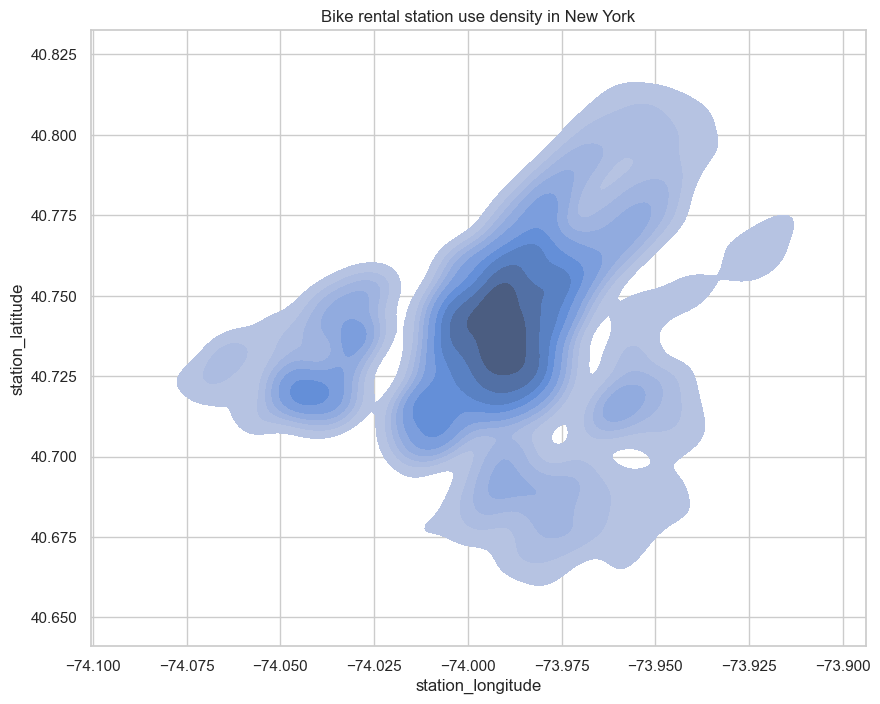

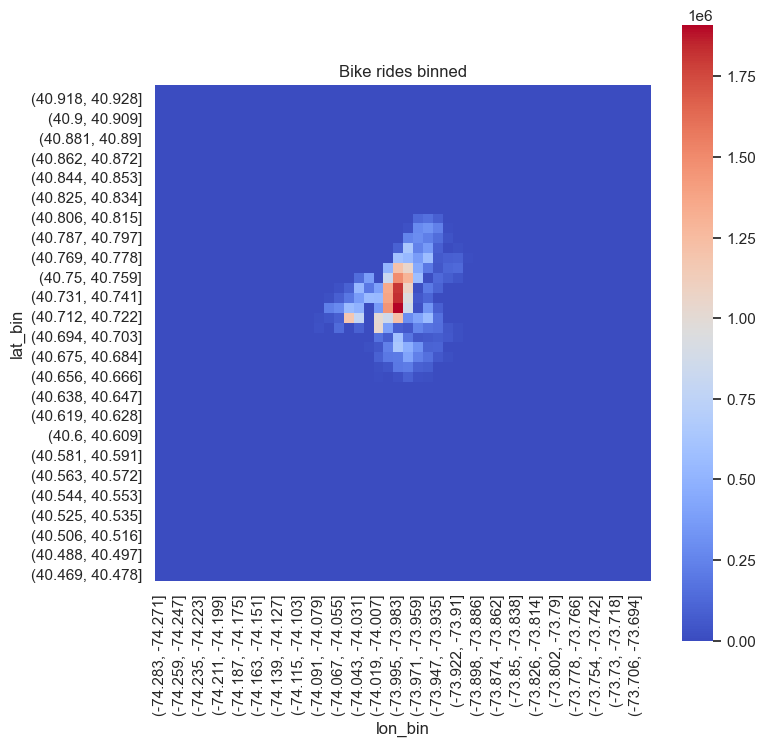

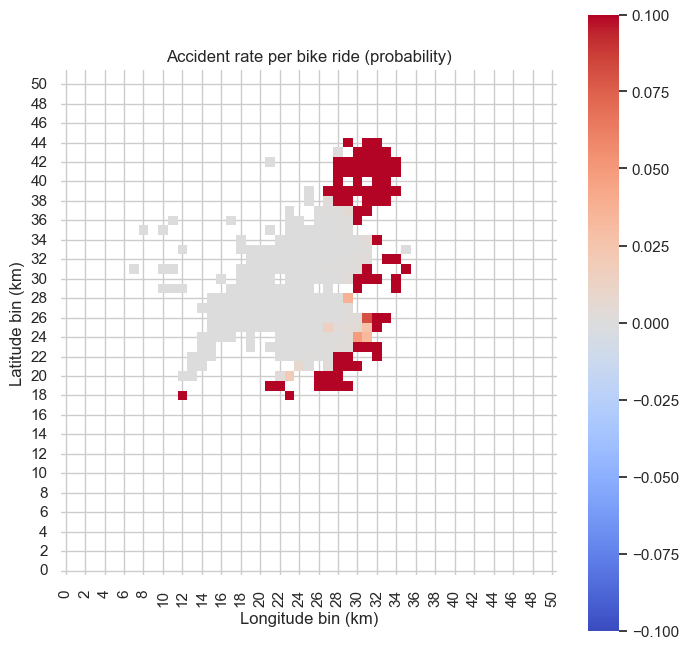

In [44]:
# Accident probability per bike ride (accident/bike ride) depending on location
# open matrix with # accidents per coordinate bin (50 x 50)
with open(results_dir +'/bike_accidents_matrix_1km_bins.pkl', "rb") as file: # load bike_accidents_matrix_50x50.pkl
    bike_accidents_matrix = pickle.load(file)
print(bike_accidents_matrix)

with open(results_dir +'/bike_rides_matrix_km_2019-2023.pkl', "rb") as file: # load bike_rides_matrix_50x50.pkl
    bike_rides_matrix = pickle.load(file)
print(bike_rides_matrix)

accident_rate_matrix = bike_accidents_matrix / bike_rides_matrix
print(accident_rate_matrix.values)

bin_size_km = 1

plt.close()
fig = plt.figure(figsize=(8, 8))   # Set the figure size to ensure it's square
ax = sns.heatmap(accident_rate_matrix, annot=False,cmap='coolwarm', square=True)  # `square=True` ensures square cells
plt.title("Accident rate per bike ride (probability)")
plt.gca().invert_yaxis()
# Set axis labels to show distances in kilometers
lat_tick_indices = ax.get_yticks().astype(int)
lon_tick_indices = ax.get_xticks().astype(int)

# Calculate the distance corresponding to each tick (km)
lat_km_labels = lat_tick_indices * bin_size_km
lon_km_labels = lon_tick_indices * bin_size_km

# Set the labels for the ticks (km)
ax.set_yticklabels(lat_km_labels)
ax.set_xticklabels(lon_km_labels)

# Set axis labels
ax.set_xlabel("Longitude bin (km)")
ax.set_ylabel("Latitude bin (km)")
plt.show()

fig.savefig(os.path.join(results_dir,f'accident_rate_heatmap_binned_km.jpg'), format='jpg') # save figure

Below, the same but creating a mask using only iverlapping bins (bins where both datasets have data, since it is largely non-overlapping. The results are the same as in the cell above though.

In [ ]:
# # matrix1: bike_accidents_matrix 
# # matrix2: bike_rides_matrix
# mask_overlap_filt = np.full((np.shape(bike_rides_matrix)[0], np.shape(bike_rides_matrix)[1]), False)
# mask_overlap_filt[(bike_accidents_matrix > 0) & (bike_rides_matrix > 0)] = True

# accident_rate_matrix = bike_accidents_matrix[mask_overlap_filt] / bike_rides_matrix[mask_overlap_filt]

# bin_size_km = 1

# plt.close()
# fig = plt.figure(figsize=(16, 8))   # Set the figure size to ensure it's square
# ax = sns.heatmap(accident_rate_matrix, annot=False, cmap='coolwarm', square=True)  # `square=True` ensures square cells
# plt.title("Accident rate per bike ride (probability)")
# plt.gca().invert_yaxis()
# # Set axis labels to show distances in kilometers
# lat_tick_indices = ax.get_yticks().astype(int)
# lon_tick_indices = ax.get_xticks().astype(int)

# # Calculate the distance corresponding to each tick (km)
# lat_km_labels = lat_tick_indices * bin_size_km
# lon_km_labels = lon_tick_indices * bin_size_km

# # Set the labels for the ticks (km)
# ax.set_yticklabels(lat_km_labels)
# ax.set_xticklabels(lon_km_labels)

# # Set axis labels
# ax.set_xlabel("Longitude bin (km)")
# ax.set_ylabel("Latitude bin (km)")
# plt.show()

# fig.savefig(os.path.join(results_dir,f'accident_rate_heatmap_binned_km_filtered.jpg'), format='jpg') # save figure

#### Try to plot a density plot, similar to what I did above, with both dataset overlapping. Unfortunately, I had memory/space issues and lack of time, and because the code is running veeery slowly, I didn´t test this block yet.

In [ ]:
df_accidents = pd.read_csv(cleaned_dir + '/collisions_cleaned.csv')
#df_accidents = pd.read_csv(cleaned_dir + '/collisions_cleaned.csv')
df_accidents = df_accidents.dropna()

fig = plt.figure(figsize=(15, 5))
sns.set_theme(style='whitegrid')

# Plot for accidents
plt.subplot(1, 3, 1)
sns.kdeplot(data=df_accidents_pd, x='accident_longitude', y='accident_latitude', fill=True)
plt.title('Accidents Density')

# Plot for bike rides
plt.subplot(1, 3, 2)
sns.kdeplot(data=rides_coords, x='station_longitude', y='station_latitude', fill=True)
plt.title('bike station use density')

# Overlay
plt.subplot(1, 3, 3)
sns.kdeplot(data=df_accidents_pd, x='accident_longitude', y='accident_latitude', fill=True, color='red', alpha=0.5)
sns.kdeplot(data=df_rides_pd, x='end_longitude', y='end_latitude', fill=True, color='blue', alpha=0.5)
plt.title('Overlay of accidents and bike station use density')

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(fig_dir, 'density_plot_accidents_bike-rides'))

### Correlations accidents and bike rides (coordinate bins)

In [45]:
x = np.array(bike_accidents_matrix.values.flatten()).reshape(-1, 1)
y = np.array(bike_rides_matrix.values.flatten())

# Add a constant (intercept term) to X for statsmodels
X = sm.add_constant(x)

# Fit linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get p-value and R²
p_value = results.pvalues[1]  # The p-value for the slope (second value, first is for intercept)
r_squared = results.rsquared

# Plot scatterplot with regression line
sns.regplot(x=x, y=y, ci=None, line_kws={"color": "red"})

# Add R² and p-value to the plot
plt.text(0.05, 0.95, f"$R^2$ = {r_squared:.2f}\n$p$ = {p_value:.3f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.xlabel('Bike accident count (#/1 km2 bin)', fontsize=16)
plt.ylabel('Bike rental count (#/1 km2 bin)', fontsize=16)
plt.title("Spatial correlation bike accident and bike rental")
plt.show()

fig.savefig(os.path.join(results_dir,'correlation_bike_accidents_rentals.jpg'), format='jpg') # save figure

NameError: name 'sm' is not defined

## More ideas (no time for, unfortunately)

Plot:
* Plot bike stations (plus labels?) over the heatmap of bike accidents/bike rentals


Correlations
* correlation bike ride duration vs age
* correlation over time (/month) # rides vs accidents

Predictions
* XGBoost or LM to predict # bike rides and bike accidents (using time & location as params)